# Testen van alle plotjes


In [707]:
import argparse
from pathlib import Path
import re
from collections import Counter
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle

# save new df to same folder as "KTO_Themes.xlsx"
output_path = "/Users/jessevdsluis/Library/CloudStorage/OneDrive-Gedeeldebibliotheken-SpringX/SpringXSharepoint - Documenten/SpringX Analytics/Klanten/Paradigma/CX/KTO/Rapportages/KTO_Themes.xlsx"
# import data.xlsx
df = pd.read_excel(output_path)

# status 2 naar status 1 als geen NPS score is gegeven (Blok1_NPS_KPI_page6_Text)
df.loc[df["Blok1_NPS_KPI_page6_Text"].isna(), "sys_respondentStatus"] = 1



# only keep df["Label"] == "Resolu"
df = df[df["Label"] == "PDG Health Services"]


In [708]:
# merge THEMES column from df_results to the end of df from df_results based on match on sys_respondentId from both



In [709]:
# ---------------------- Theme ----------------------
BG = "#062B36"          # page background
CARD = "#2E3136"        # panel/axes
GRID = "#3A3D42"        # subtle grid
TEXT = "#E5E7EB"        # main text
SUBTLE = "#A7B0B7"      # subtle labels
TEAL = "#10B981"        # accent 1
PURPLE = "#7C3AED"      # accent 2
WHITE = "#FFFFFF"       # white
BAR_BG = "#4B4F55"   # achtergrond van de progressbar


def apply_theme():
    plt.rcParams.update({
        "figure.facecolor": BG,
        "axes.facecolor": CARD,
        "axes.edgecolor": CARD,
        "axes.labelcolor": TEXT,
        "xtick.color": SUBTLE,
        "ytick.color": SUBTLE,
        "text.color": TEXT,
        "axes.titleweight": "bold",
        "axes.titlepad": 16,
        "font.size": 11
    })

def style_axes(ax, title=None):
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="y", color=GRID, linewidth=0.8, alpha=0.5)
    if title:
        ax.set_title(title, fontsize=16, weight="bold", loc="left", pad=12)

# ---------------------- Helper: Gauge ----------------------
def draw_gauge(value, vmin, vmax, title, accent=TEAL, subtitle=None, fname=None, outdir=None):
    """Draw a semi-circular gauge and save to outdir/fname. Returns the path."""
    value = float(np.clip(value, vmin, vmax))
    fig, ax = plt.subplots(figsize=(5.5, 4.0), dpi=180)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_facecolor(CARD)

    radius = 1.0
    center = (0, 0)

    # Background arc
    bg_arc = Wedge(center, r=radius, theta1=180, theta2=0, width=0.18,
                   facecolor="#4B4F55", edgecolor="none", alpha=0.9)
    ax.add_patch(bg_arc)

    # Progress arc
    frac = (value - vmin) / (vmax - vmin + 1e-9)
    theta = 180 - 180 * frac
    prog = Wedge(center, r=radius, theta1=180, theta2=theta, width=0.18,
                 facecolor=accent, edgecolor="none")
    ax.add_patch(prog)

    # Needle
    needle_len = radius * 0.9
    angle_rad = np.deg2rad(theta)
    x, y = needle_len * np.cos(angle_rad), needle_len * np.sin(angle_rad)
    ax.plot([0, x], [0, y], lw=4, color=accent)
    ax.add_patch(Circle(center, 0.06, color=accent))

    # Ticks
    for t in np.linspace(180, 0, 7):
        ax.plot([0.92*np.cos(np.deg2rad(t)), 1.05*np.cos(np.deg2rad(t))],
                [0.92*np.sin(np.deg2rad(t)), 1.05*np.sin(np.deg2rad(t))],
                lw=2, color=GRID)

    # Titles / values
    ax.text(0, 0.55, title, ha="center", va="center", fontsize=13, weight="bold", color=TEXT)
    big = f"{value:.0f}" if (vmax - vmin) > 1 else f"{value:.1f}"
    ax.text(0, -0.05, big, ha="center", va="center", fontsize=30, weight="bold", color=TEXT)
    if subtitle:
        ax.text(0, -0.32, subtitle, ha="center", va="center", fontsize=11, color=SUBTLE)

    fig.patch.set_facecolor(BG)
    outdir = Path(outdir or ".")
    outdir.mkdir(parents=True, exist_ok=True)
    p = outdir / (fname or "gauge.png")
    fig.tight_layout()
    fig.savefig(p, dpi=220, bbox_inches="tight", facecolor=BG)
    plt.close(fig)
    return p


### Aantal respondenten

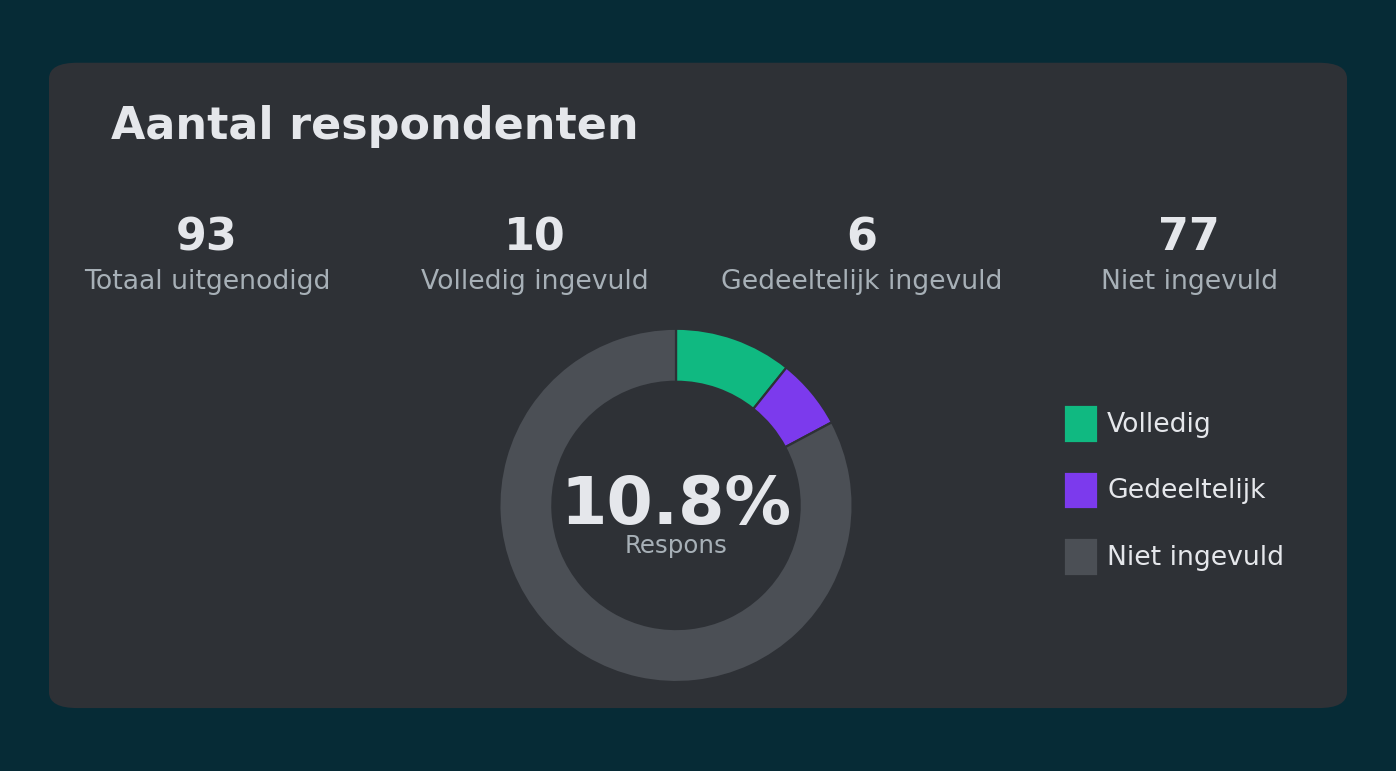

In [710]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle
from pathlib import Path

# ---------- Thema (zelfde look & feel) ----------
BG     = "#062B36"   # page background
CARD   = "#2E3136"   # dark card
TEXT   = "#E5E7EB"   # main text
SUBTLE = "#A7B0B7"   # subtle labels
GRID   = "#3A3D42"   # subtle strokes
TEAL   = "#10B981"   # accent: volledig
PURPLE = "#7C3AED"   # accent: gedeeltelijk
BAR_BG = "#474C53"   # bar background

plt.rcParams.update({
    "figure.facecolor": BG,
    "axes.facecolor": BG,          # we tekenen zelf een 'card'
    "axes.edgecolor": BG,
    "axes.labelcolor": TEXT,
    "xtick.color": SUBTLE,
    "ytick.color": SUBTLE,
    "text.color": TEXT,
    "axes.titleweight": "bold",
    "font.size": 11
})


# Bereken aantal uitgenodigd, volledig en gedeeltelijk
no_response = int((df["sys_respondentStatus"] == 1).sum()) if "sys_respondentStatus" in df.columns else 0
volledig       = int((df["sys_respondentStatus"] == 3).sum()) if "sys_respondentStatus" in df.columns else 0
gedeeltelijk   = int((df["sys_respondentStatus"] == 2).sum()) if "sys_respondentStatus" in df.columns else 0
uitgenodigd_tot = no_response + volledig + gedeeltelijk


if not no_response or no_response < (volledig + gedeeltelijk):
    uitgenodigd = volledig + gedeeltelijk

respons = 0 if uitgenodigd_tot == 0 else (volledig / uitgenodigd_tot) * 100
p_vol = 0 if uitgenodigd_tot == 0 else volledig / uitgenodigd_tot
p_ged = 0 if uitgenodigd_tot == 0 else gedeeltelijk / uitgenodigd_tot


# ---------- Plot ----------

import matplotlib.patches as mpatches

# (re)calc respons op basis van de 4 variabelen
respons = 0 if uitgenodigd_tot == 0 else (volledig / uitgenodigd_tot) * 100

fig, ax = plt.subplots(figsize=(11, 6), dpi=160)
ax.set_axis_off()
ax.set_xlim(0, 1); ax.set_ylim(0, 1)

# Card achtergrond (met afgeronde hoeken)
card = FancyBboxPatch((0.04, 0.08), 0.92, 0.84,
                      boxstyle="round,pad=0.015,rounding_size=0.02",
                      facecolor=CARD, edgecolor=CARD)
ax.add_patch(card)

# Titel
ax.text(0.07, 0.85, "Aantal respondenten",
        fontsize=20, weight="bold", ha="left", va="center")

# KPI-rij (links -> rechts): Niet ingevuld, Volledig, Gedeeltelijk, Totaal uitgenodigd
def stat_box(x, y, value, label):
    ax.text(x, y, f"{value:,}".replace(",", "."),
            fontsize=20, weight="bold", ha="center", va="center", color=TEXT)
    ax.text(x, y-0.06, label,
            fontsize=12, ha="center", va="center", color=SUBTLE)

stat_y = 0.70
stat_box(0.14, stat_y, uitgenodigd_tot, "Totaal uitgenodigd")
stat_box(0.38, stat_y, volledig,        "Volledig ingevuld")
stat_box(0.62, stat_y, gedeeltelijk,    "Gedeeltelijk ingevuld")
stat_box(0.86, stat_y, no_response,     "Niet ingevuld")

# --- Donut pie gecentreerd en duidelijk lager dan de KPI's ---
sizes  = [volledig, gedeeltelijk, no_response]
labels = ["Volledig", "Gedeeltelijk", "Niet ingevuld"]
colors = [TEAL, PURPLE, "#4B4F55"]

# positie donut (lager zetten met pie_bottom)
pie_w, pie_h = 0.44, 0.46            # breedte/hoogte
pie_left     = 0.5 - pie_w/2         # gecentreerd
pie_bottom   = 0.14                  # <- lager
ax_pie = fig.add_axes([pie_left, pie_bottom, pie_w, pie_h])
ax_pie.set_facecolor(CARD)
ax_pie.set_aspect("equal")

wedges, _ = ax_pie.pie(
    sizes,
    colors=colors,
    startangle=90,
    counterclock=False,
    wedgeprops=dict(width=0.30, edgecolor=CARD)   # donut-look
)

# respons in het midden
ax_pie.text(0,  0.00, f"{respons:.1f}%", ha="center", va="center",
            fontsize=30, weight="bold", color=TEXT)
ax_pie.text(0, -0.23, "Respons", ha="center", va="center",
            fontsize=11, color=SUBTLE)

# Legenda rechts van de donut (mee naar beneden geplaatst)
lx = pie_left + pie_w + 0.05
legend_items = [("Volledig", TEAL), ("Gedeeltelijk", PURPLE), ("Niet ingevuld", "#4B4F55")]
for i, (lab, col) in enumerate(legend_items):
    y = pie_bottom + pie_h*0.62 - i*0.09
    ax.add_patch(mpatches.Rectangle((lx, y), 0.022, 0.045, color=col))
    ax.text(lx + 0.03, y + 0.022, lab, va="center", color=TEXT, fontsize=12)

plt.show()


##### Gebruik vanaf nu alleen gedeeltelijk en volledig

In [711]:
# only keep df[df["sys_respondentStatus"] == 2 | df["sys_respondentStatus"] == 3]
df = df[(df["sys_respondentStatus"] == 2) | (df["sys_respondentStatus"] == 3)]

print(len(df))



16


### Aanbeveling

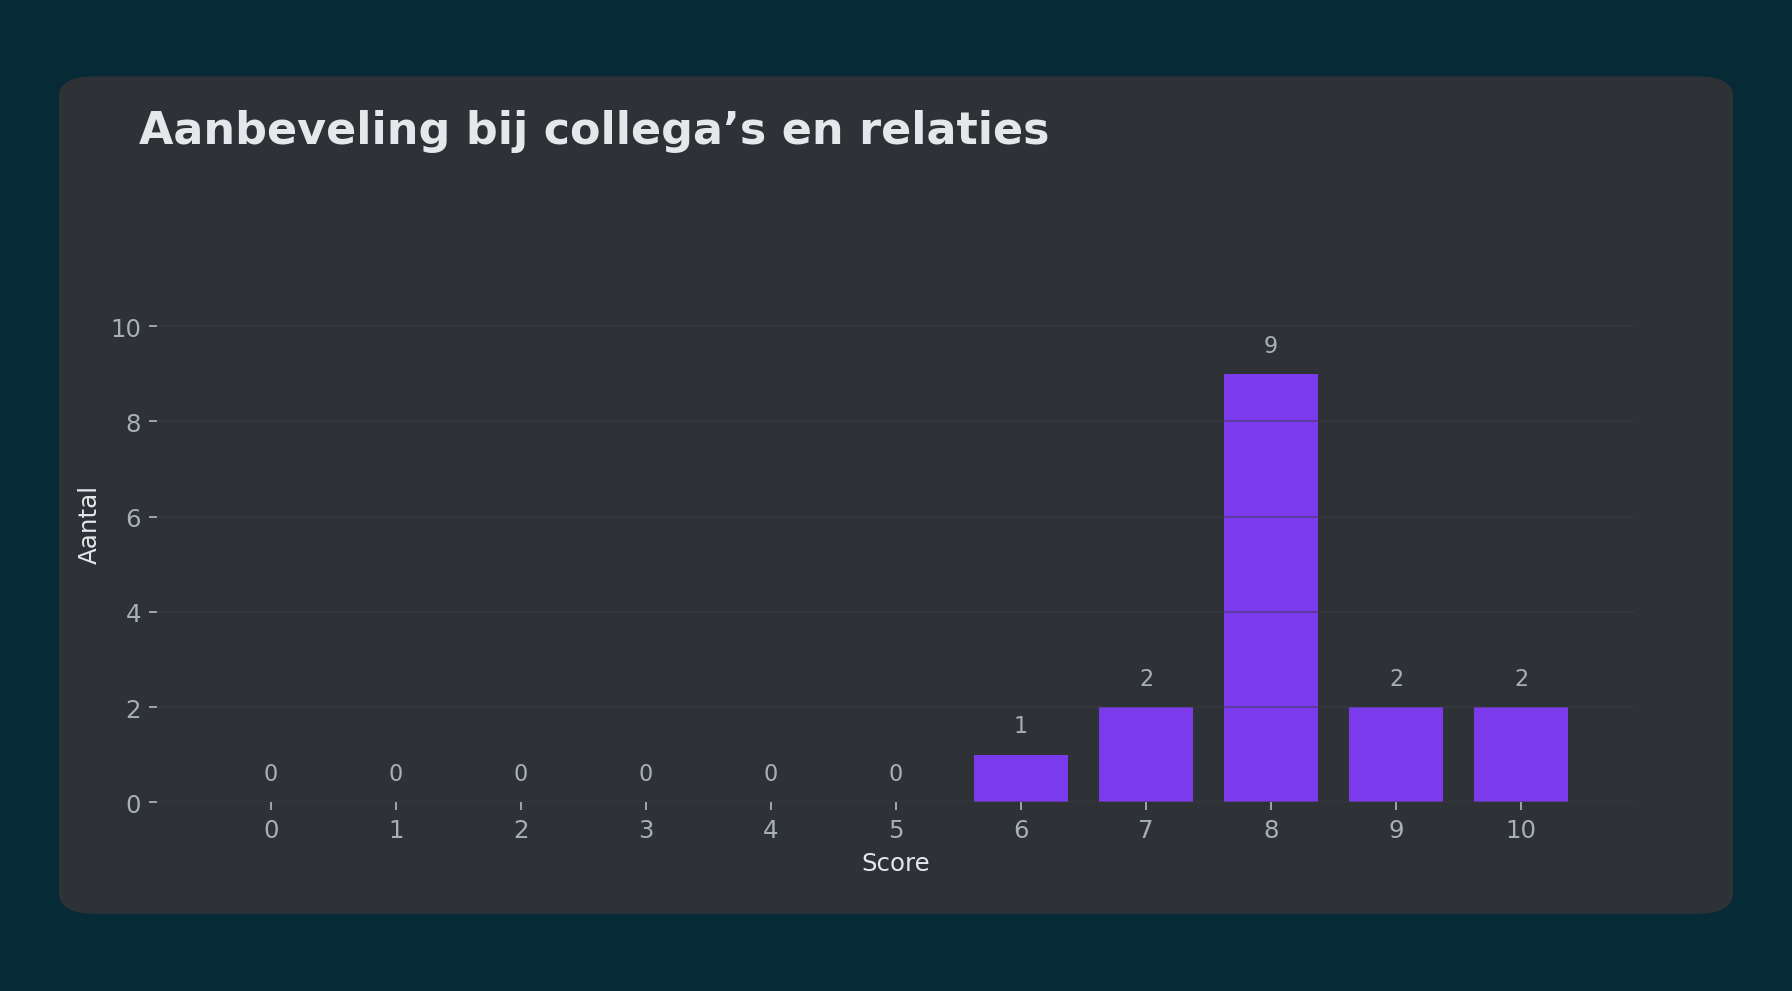

In [712]:
def plot_aanbeveling_distribution(df, outdir=None):
    """Bar chart 0..10 for Blok1_NPS_KPI_page6_Text (display only, do not save)
       Styled like the donut/pie card.
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyBboxPatch

    # palette (falls back if not defined in globals)
    BG     = globals().get("BG",     "#062B36")
    CARD   = globals().get("CARD",   "#2E3136")
    TEXT   = globals().get("TEXT",   "#E5E7EB")
    SUBTLE = globals().get("SUBTLE", "#A7B0B7")
    GRID   = globals().get("GRID",   "#3A3D42")
    PURPLE = globals().get("PURPLE", "#7C3AED")

    col = "Blok1_NPS_KPI_page6_Text"
    if col not in df.columns:
        print(f"Kolom '{col}' niet gevonden.")
        return None

    s = df[col].dropna().astype(int)
    idx = list(range(0, 11))
    counts = s.value_counts().reindex(idx, fill_value=0)

    # --- Figure with card background (same as donut style) ---
    fig = plt.figure(figsize=(11, 6), dpi=160)
    ax_card = fig.add_axes([0, 0, 1, 1])
    ax_card.set_axis_off()
    ax_card.set_xlim(0, 1); ax_card.set_ylim(0, 1)

    # Rounded card
    card = FancyBboxPatch((0.04, 0.08), 0.92, 0.84,
                          boxstyle="round,pad=0.015,rounding_size=0.02",
                          facecolor=CARD, edgecolor=CARD, zorder=1)
    ax_card.add_patch(card)

    # Title ON THE FIGURE (so it never gets hidden)
    fig.text(0.07, 0.88, "Aanbeveling bij collega’s en relaties",
             fontsize=20, weight="bold", ha="left", va="center",
             color=TEXT, zorder=5)

    # Inner axes for the bar plot, slightly lower to leave room for title
    ax = fig.add_axes([0.08, 0.18, 0.84, 0.58])  # [left,bottom,width,height]
    ax.set_facecolor(CARD)

    bars = ax.bar(idx, counts.values, width=0.75, color=PURPLE)

    # Dashboard styling
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="y", color=GRID, linewidth=0.8, alpha=0.5)
    ax.set_xlabel("Score", color=TEXT)
    ax.set_ylabel("Aantal", color=TEXT)
    ax.set_xticks(idx)
    ymax = max(counts.values.tolist() + [1])
    ax.set_ylim(0, ymax * 1.30)      # extra headroom so labels don’t hit the card
    ax.tick_params(colors=SUBTLE)

    # Value labels
    for b in bars:
        ax.text(
            b.get_x() + b.get_width() / 2,
            b.get_height() + ymax * 0.04,   # a bit more space
            f"{int(b.get_height())}",
            ha="center", va="bottom", color=SUBTLE, fontsize=10,
        )

    fig.patch.set_facecolor(BG)
    plt.show()
    plt.close(fig)
    return None

# use this function to plot the aanbeveling distribution
plot_aanbeveling_distribution(df)


### Duur samenwerking

In [713]:
def plot_duur_samenwerking_gauges(df, column_name="Blok7_3 Duur samenwerking_page74_Text", title="Duur samenwerking"):
    """
    Card-style HALF-donut gauges (full width, compact height):
    - one mini-axes per gauge → no touching
    - true circles (equal aspect), top-half ring
    - % centered inside each gauge, label below
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyBboxPatch, Wedge
    import pandas as pd

    # only if Label == "Resolu"
    if LABEL != "Resolu":
        return None
    # palette (use globals if available)
    BG      = globals().get("BG",     "#062B36")
    CARD    = globals().get("CARD",   "#2E3136")
    TEXT    = globals().get("TEXT",   "#E5E7EB")
    TEAL    = globals().get("TEAL",   "#10B981")
    RING_BG = globals().get("RING_BG","#4B4F55")

    # Get data from the column
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in dataframe")
        return None
    
    # Count values and calculate percentages
    counts = df[column_name].value_counts().sort_index()
    total = len(df[column_name].dropna())
    
    if total == 0:
        print("No valid data found in the column")
        return None
    
    # Calculate percentages
    percentages = [(count / total) * 100 for count in counts.values]
    values = counts.index.tolist()
    
    # Create proper labels based on values
    labels = []
    for value in values:
        if value == 1:
            labels.append("0-1 jaar")
        elif value == 2:
            labels.append("1-2 jaar")
        elif value == 3:
            labels.append("2-5 jaar")
        elif value == 4:
            labels.append("5 jaar")
        else:
            labels.append(str(value))  # fallback for unexpected values
    
    n = len(percentages)

    # ==== Figure + rounded card ====
    fig = plt.figure(figsize=(11, 4.8), dpi=160)
    ax_card = fig.add_axes([0, 0, 1, 1]); ax_card.axis("off")
    ax_card.set_xlim(0, 1); ax_card.set_ylim(0, 1)
    ax_card.add_patch(FancyBboxPatch((0.04, 0.08), 0.92, 0.84,
                                     boxstyle="round,pad=0.015,rounding_size=0.02",
                                     facecolor=CARD, edgecolor=CARD, zorder=1))
    fig.text(0.07, 0.88, title, fontsize=20, weight="bold",
             ha="left", va="center", color=TEXT, zorder=5)

    # ==== Layout for mini-axes (full width, compact height) ====
    inner_left, inner_right = 0.06, 0.94        # within the card
    inner_bottom, inner_height = 0.34, 0.30     # compact row height (move up/down here)
    gutter = 0.02                               # gap between gauges

    cell_w = (inner_right - inner_left - gutter*(n-1)) / n
    gauge_h = inner_height                      # each mini-axes height
    centers = [inner_left + i*(cell_w + gutter) for i in range(n)]

    # geometry inside each mini-axes (data coords) - BIGGER GAUGES
    RADIUS = 1.5                                 # increased from 1.0 to make gauge bigger
    WIDTH  = 0.5                                # ring thickness relative to radius
    pct_fs, lab_fs = 22, 18                     # increased font sizes from 16,14 to 22,18

    for i, (pct, lab) in enumerate(zip(percentages, labels)):
        # one mini-axes per gauge
        axg = fig.add_axes([centers[i], inner_bottom, cell_w, gauge_h])
        axg.set_aspect("equal")
        axg.set_xlim(-1.8, 1.8)                 # adjusted limits for bigger gauge
        axg.set_ylim(-1.0, 1.6)                 # adjusted limits for bigger gauge
        axg.axis("off")

        pct = float(max(0, min(100, pct)))

        # background half ring (top half 0..180°)
        axg.add_patch(Wedge((0, 0), RADIUS, 0, 180,
                            width=WIDTH, facecolor=RING_BG, edgecolor="none"))
        # value arc (fill left → right along the top)
        if pct > 0:
            start = 180 - (pct/100.0)*180.0
            axg.add_patch(Wedge((0, 0), RADIUS, start, 180,
                                width=WIDTH, facecolor=TEAL, edgecolor="none"))

        # % centered inside the half donut
        axg.text(0, 0.2, f"{int(round(pct))}%", ha="center", va="center",
                 color=TEXT, fontsize=pct_fs)

        # label below
        axg.text(0, -0.7, str(lab), ha="center", va="center",
                 color=TEXT, fontsize=lab_fs, weight="bold")

    fig.patch.set_facecolor(BG)
    plt.show()
    plt.close(fig)

# use this function to plot the duur samenwerking distribution
plot_duur_samenwerking_gauges(df, "Blok7_3 Duur samenwerking_page74_Text")


No valid data found in the column


### NPS

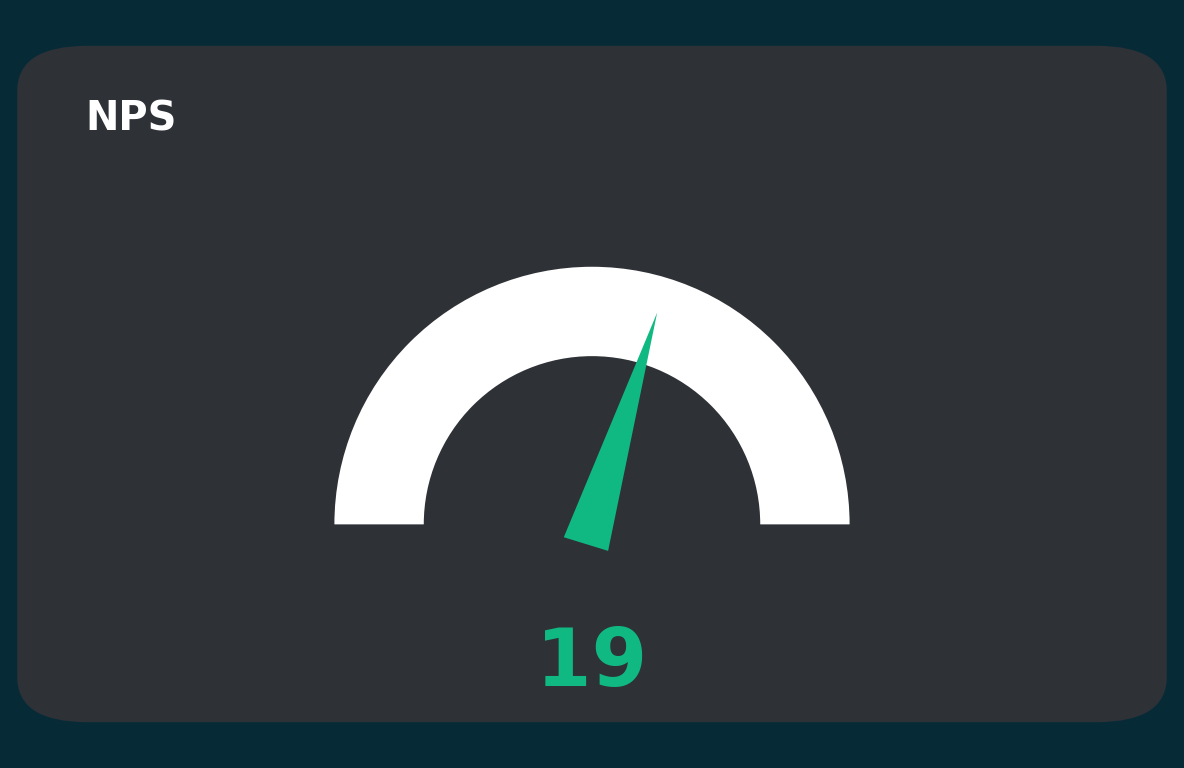

In [714]:
def create_nps_gauge(df, column):
    """
    Create an NPS gauge visualization (US style).
    - Promoters: 9–10
    - Passives: 7–8
    - Detractors: 0–6
    - NPS = %Promoters - %Detractors, displayed as an integer (−100..100)
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyBboxPatch, Wedge, Polygon

    # --- Calculate NPS (US style) ---
    s = pd.to_numeric(pd.Series(df[column]), errors="coerce").dropna()
    if len(s) == 0:
        nps_score = 0
    else:
        promoters = (s >= 9).sum()
        detractors = (s <= 6).sum()
        total = len(s)

        pct_promoters = (promoters / total) * 100.0
        pct_detractors = (detractors / total) * 100.0
        nps_score = int(round(pct_promoters - pct_detractors))
        nps_score = int(np.clip(nps_score, -100, 100))  # safety clamp

    # --------- SETTINGS ----------
    TITLE       = "NPS"
    SCORE       = nps_score
    VMIN, VMAX  = -100.0, 100.0

    # Palette (uses your globals if set)
    BG    = globals().get("BG",   "#062B36")
    CARD  = globals().get("CARD", "#2E3136")
    TEXT  = globals().get("TEXT", "#E5E7EB")
    TEAL  = globals().get("TEAL", "#10B981")
    WHITE = "#FFFFFF"

    FIGSIZE    = (7.2, 4.6)
    RADIUS     = 0.98
    RING_THICK = 0.34
    # -----------------------------

    # Needle angle
    frac = float(np.clip((SCORE - VMIN) / max(1e-9, (VMAX - VMIN)), 0, 1))
    theta = np.deg2rad(180 * (1 - frac))   # 180° (left) -> 0° (right)

    # Figure + rounded card
    fig = plt.figure(figsize=FIGSIZE, dpi=160)
    ax_card = fig.add_axes([0, 0, 1, 1]); ax_card.axis("off")
    ax_card.set_xlim(0, 1); ax_card.set_ylim(0, 1)
    ax_card.add_patch(FancyBboxPatch((0.02, 0.06), 0.96, 0.88,
                                     boxstyle="round,pad=0.018,rounding_size=0.06",
                                     facecolor=CARD, edgecolor=CARD))
    fig.text(0.06, 0.86, TITLE, fontsize=18, weight="bold",
             color=WHITE, ha="left", va="center")

    # Gauge axes
    ax = fig.add_axes([0.06, 0.22, 0.88, 0.50])
    ax.set_aspect("equal"); ax.axis("off")
    ax.set_xlim(-1.1, 1.1); ax.set_ylim(-0.25, 1.15)

    # White half-donut
    ax.add_patch(Wedge((0, 0), RADIUS, 0, 180, width=RING_THICK,
                       facecolor=WHITE, edgecolor="none", zorder=1))

    # ----- Polygon needle -----
    tip_len    = RADIUS * 0.86
    base_back  = RADIUS * 0.08
    base_width = RADIUS * 0.18

    tx, ty = tip_len * np.cos(theta), tip_len * np.sin(theta)
    bx, by = -base_back * np.cos(theta), -base_back * np.sin(theta)
    px = np.cos(theta + np.pi/2) * (base_width/2)
    py = np.sin(theta + np.pi/2) * (base_width/2)

    needle = Polygon([[bx - px, by - py],
                      [bx + px, by + py],
                      [tx,      ty     ]],
                     closed=True, facecolor=TEAL, edgecolor="none", zorder=3)
    ax.add_patch(needle)

    # Big number (US formatting: whole number, no comma replacement)
    fig.text(0.50, 0.12, f"{SCORE:d}", ha="center", va="center",
             fontsize=36, weight="bold", color=TEAL)

    fig.patch.set_facecolor(BG)
    plt.show()
    plt.close(fig)


# create_nps_gauge (df, )

create_nps_gauge(df, "Blok1_NPS_KPI_page6_Text")

### Informatie voorzieningen Resolu

In [715]:
column = "Blok7_VoorafGeinformeerd_Resolu_page128_Text"

In [716]:


def create_informatievoorziening_card(df, column):
    """
    Create an information provision card visualization with pie chart.
    
    Parameters:
    df: pandas DataFrame containing the data
    column: string, column name to visualize
    """
    if LABEL != "Resolu":
        return None
    else:
        TITLE_LINES = ["Informatie", "voorziening"]
        # Insert explicit newline so text never runs into the pie
        QUESTION    = "Bent u goed geïnformeerd\nvoor het afnemen van de dienst?"

    BG     = globals().get("BG",     "#062B36")
    CARD   = globals().get("CARD",   "#2E3136")
    TEXT   = globals().get("TEXT",   "#E5E7EB")

    CODE2LABEL = {5:"Zeer tevreden", 4:"Tevreden", 3:"Neutraal", 2:"Ontevreden", 1:"Zeer ontevreden"}
    PIE_COLORS = ["#4E6591", "#2D7DA6", "#69D2E7", "#8AD0DF", "#6B57A8"]

    s = pd.to_numeric(pd.Series(df[column]), errors="coerce").dropna().astype(int)
    order = [5,4,3,2,1]
    labels = [CODE2LABEL[k] for k in order]
    vals   = s.map(CODE2LABEL).value_counts().reindex(labels, fill_value=0).values.astype(float)
    total  = vals.sum() if vals.sum() > 0 else 1.0
    fracs  = vals / total

    fig = plt.figure(figsize=(12.8, 4.2), dpi=160)
    ax_card = fig.add_axes([0,0,1,1]); ax_card.axis("off")
    ax_card.set_xlim(0,1); ax_card.set_ylim(0,1)
    ax_card.add_patch(FancyBboxPatch((0.02,0.06), 0.96, 0.88,
                                     boxstyle="round,pad=0.018,rounding_size=0.06",
                                     facecolor=CARD, edgecolor=CARD))

    # --- Left text block ---
    ax_text = fig.add_axes([0.06, 0.14, 0.38, 0.74])
    ax_text.axis("off")
    ax_text.text(0.0, 0.92, TITLE_LINES[0], fontsize=30, weight="bold", color=TEXT, ha="left", va="top")
    ax_text.text(0.0, 0.78, TITLE_LINES[1], fontsize=30, weight="bold", color=TEXT, ha="left", va="top")
    # Question with newline already inserted - made smaller
    ax_text.text(0.0, 0.50, QUESTION, fontsize=16, weight="bold",
                 color=TEXT, ha="left", va="top", linespacing=1.4)

    # --- Pie on the right - made bigger ---
    ax_pie = fig.add_axes([0.46, 0.08, 0.40, 0.84])
    ax_pie.set_aspect("equal"); ax_pie.axis("off")

    wedges, _ = ax_pie.pie(fracs, colors=PIE_COLORS[:len(fracs)],
                           startangle=120, counterclock=False,
                           wedgeprops=dict(width=1.0, edgecolor=CARD))

    # --- Legend - made bigger ---
    ax_legend = fig.add_axes([0.87, 0.14, 0.12, 0.72])
    ax_legend.axis("off")

    for i, (lab, frac, color) in enumerate(zip(labels, fracs, PIE_COLORS[:len(fracs)])):
        y_pos = 0.9 - i * 0.18
        # Color box
        ax_legend.add_patch(FancyBboxPatch((0.0, y_pos-0.03), 0.08, 0.06,
                                           boxstyle="square,pad=0.01",
                                           facecolor=color, edgecolor="none"))
        # Label and percentage - made bigger
        ax_legend.text(0.12, y_pos, f"{lab}\n{frac*100:.1f}%", 
                       fontsize=11, weight="bold", color=TEXT, ha="left", va="center")

    fig.patch.set_facecolor(BG)
    plt.show()

# Example usage:
COL = "Blok7_VoorafGeinformeerd_Resolu_page128_Text"
create_informatievoorziening_card(df, COL)


/Users/jessevdsluis/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/matplotlib/axes/_axes.py:3162: RuntimeWarning: invalid value encountered in true_divide
  x = x / sx


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 2048x672 with 3 Axes>

### Afgenomen Diensten

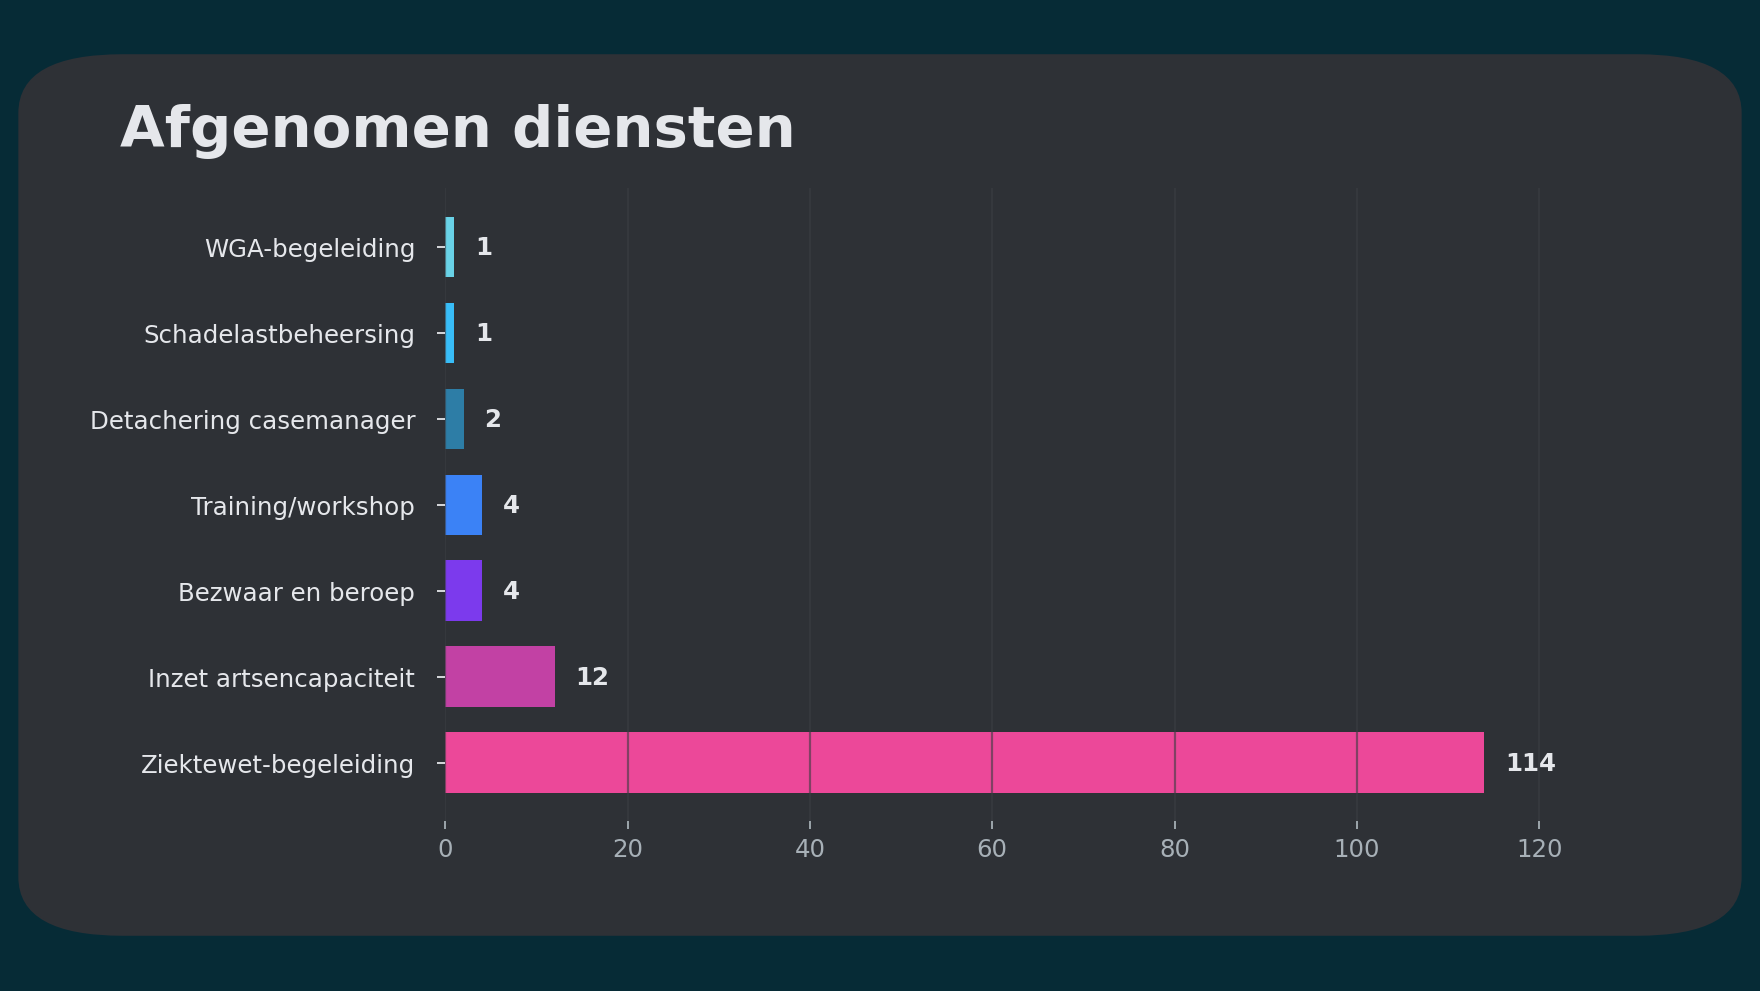

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def create_afgenomen_diensten_from_flags(df, title="Afgenomen diensten"):
    if LABEL == "PDG Health Services":
        FLAG_MAP = {
            "RI&E": "WelkeDiensten_PDG_page95_Text_1",
            "Verdiepende onderzoeken": "WelkeDiensten_PDG_page95_Text_2",
        "PMO /PAGO": "WelkeDiensten_PDG_page95_Text_3",
        "FIT-check, Fysio Vitaal en overig": "WelkeDiensten_PDG_page95_Text_4",
    }
    elif LABEL == "Resolu":
                FLAG_MAP = {
            "Detachering casemanager": "Introductie_Resolu_Diensten_page123_Text_1",
            "Bezwaar en beroep":       "Introductie_Resolu_Diensten_page123_Text_2",
        "Schadelastbeheersing":    "Introductie_Resolu_Diensten_page123_Text_3",
        "Ziektewet-begeleiding":   "Introductie_Resolu_Diensten_page123_Text_4",
        "Inzet artsencapaciteit":  "Introductie_Resolu_Diensten_page123_Text_5",
        "WGA-begeleiding":         "Introductie_Resolu_Diensten_page123_Text_6",
        "WW-ondersteuning":        "Introductie_Resolu_Diensten_page123_Text_7",
            "Training/workshop":       "Introductie_Resolu_Diensten_page123_Text_8",
        }
    else:
        return None

    BG     = globals().get("BG",     "#062B36")
    CARD   = globals().get("CARD",   "#2E3136")
    GRID   = globals().get("GRID",   "#3A3D42")
    TEXT   = globals().get("TEXT",   "#E5E7EB")
    SUBTLE = globals().get("SUBTLE", "#A7B0B7")

    COLORS = ["#69D2E7", "#38BDF8", "#2D7DA6", "#3B82F6", "#7C3AED", "#C241A4", "#EC4899"]

    counts = {}
    for label, col in FLAG_MAP.items():
        if col in df.columns:
            s = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
            counts[label] = int((s == 1).sum())
        else:
            counts[label] = 0

    counts = {k: v for k, v in counts.items() if v > 0}
    if not counts:
        print("Geen geselecteerde diensten.")
        return None

    items  = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
    labels = [k for k, _ in items][::-1]
    values = [v for _, v in items][::-1]

    fig = plt.figure(figsize=(10.8, 6.0), dpi=160)
    ax_card = fig.add_axes([0, 0, 1, 1]); ax_card.axis("off")
    ax_card.set_xlim(0, 1); ax_card.set_ylim(0, 1)
    ax_card.add_patch(FancyBboxPatch((0.02, 0.06), 0.96, 0.88,
                                     boxstyle="round,pad=0.018,rounding_size=0.06",
                                     facecolor=CARD, edgecolor=CARD))

    fig.text(0.06, 0.88, title, fontsize=26, weight="bold", color=TEXT, ha="left", va="center")

    # Calculate dynamic left margin based on longest label
    # Create a temporary text object to measure label widths
    temp_text = fig.text(0, 0, "", fontsize=11, color=TEXT)
    max_label_width = 0
    
    for label in labels:
        temp_text.set_text(label)
        bbox = temp_text.get_window_extent(renderer=fig.canvas.get_renderer())
        # Convert to figure coordinates
        label_width_fig = bbox.width / fig.dpi / fig.get_figwidth()
        max_label_width = max(max_label_width, label_width_fig)
    
    temp_text.remove()  # Clean up temporary text
    
    # Set left margin with padding: card margin (0.02) + padding (0.02) + label width + extra padding (0.02)
    LEFT_MARGIN = 0.02 + 0.02 + max_label_width + 0.02
    
    # Ensure we don't take up too much space (max 40% of figure width for labels)
    LEFT_MARGIN = min(LEFT_MARGIN, 0.4)
    
    # Create the chart axes with dynamic positioning
    ax = fig.add_axes([LEFT_MARGIN, 0.16, 0.94 - LEFT_MARGIN, 0.66])
    ax.set_facecolor(CARD)
    for sp in ax.spines.values():
        sp.set_visible(False)

    ax.tick_params(axis="x", colors=SUBTLE)
    ax.tick_params(axis="y", colors=TEXT, labelsize=11, pad=10)

    y = np.arange(len(labels))
    bar_colors = [COLORS[i % len(COLORS)] for i in range(len(labels))]
    bars = ax.barh(y, values, height=0.7, color=bar_colors, edgecolor="none")

    ax.set_yticks(y, labels)
    ax.invert_yaxis()
    ax.grid(axis="x", color=GRID, linewidth=1.0, alpha=0.6)

    xmax = max(values)
    for b, v in zip(bars, values):
        ax.text(b.get_width() + xmax * 0.02, b.get_y() + b.get_height() / 2,
                f"{int(v)}", va="center", ha="left", color=TEXT, fontsize=11, weight="bold")

    # Add headroom for numbers
    ax.set_xlim(0, xmax * 1.15)

    fig.patch.set_facecolor(BG)
    plt.show()
    return fig

fig = create_afgenomen_diensten_from_flags(df)

### Functiegroep

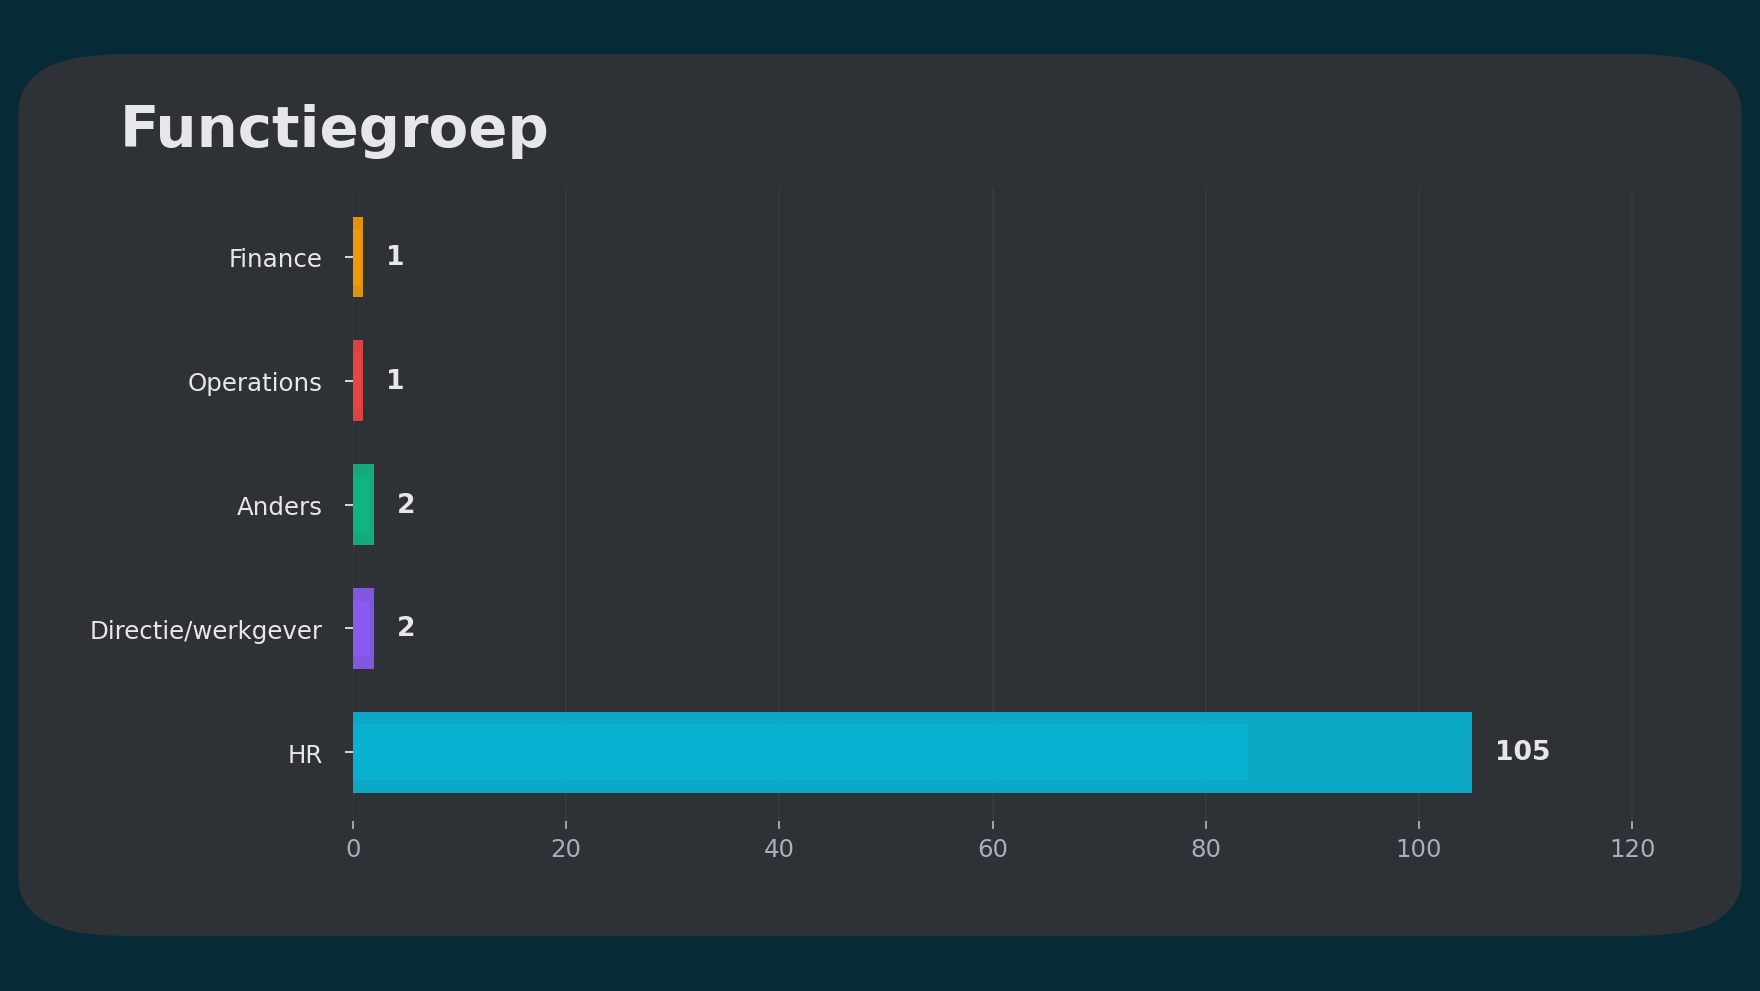

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def create_functiegroep_chart(df, title="Functiegroep"):
    # Mapping of function groups to their column values
    FUNCTIE_MAP = {
        "Directie/werkgever": "1",
        "HR": "2", 
        "Operations": "3",
        "Finance": "4",
        "Anders": "5"
    }
    
    COLUMN_NAME = "Blok4_1_page22_Text"
    
    # Different color scheme for function groups - warmer tones
    COLORS = ["#F59E0B", "#EF4444", "#10B981", "#8B5CF6", "#06B6D4"]
    
    # Count occurrences of each function group
    counts = {}
    if COLUMN_NAME in df.columns:
        column_data = df[COLUMN_NAME].dropna()  # Remove NaN values first
        for label, value in FUNCTIE_MAP.items():
            # Handle both string and float comparisons
            value_float = float(value)
            count = int((column_data == value_float).sum())
            if count > 0:
                counts[label] = count
    
    if not counts:
        print("Geen functiegroep data gevonden.")
        return None
    
    # Sort by count (descending) but display ascending for horizontal bars
    items = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
    labels = [k for k, _ in items][::-1]
    values = [v for _, v in items][::-1]
    
    fig = plt.figure(figsize=(10.8, 6.0), dpi=160)
    ax_card = fig.add_axes([0, 0, 1, 1]); ax_card.axis("off")
    ax_card.set_xlim(0, 1); ax_card.set_ylim(0, 1)
    ax_card.add_patch(FancyBboxPatch((0.02, 0.06), 0.96, 0.88,
                                     boxstyle="round,pad=0.018,rounding_size=0.06",
                                     facecolor=CARD, edgecolor=CARD))
    
    fig.text(0.06, 0.88, title, fontsize=26, weight="bold", color=TEXT, ha="left", va="center")
    
    # Function to wrap long labels
    def wrap_label(label, max_width_chars=30):
        if len(label) <= max_width_chars:
            return label
        words = label.split()
        lines = []
        current_line = []
        current_length = 0
        
        for word in words:
            if current_length + len(word) + 1 > max_width_chars and current_line:
                lines.append(' '.join(current_line))
                current_line = [word]
                current_length = len(word)
            else:
                current_line.append(word)
                current_length += len(word) + (1 if current_line else 0)
        
        if current_line:
            lines.append(' '.join(current_line))
        
        return '\n'.join(lines)
    
    # Wrap long labels
    wrapped_labels = [wrap_label(label) for label in labels]
    
    # Calculate dynamic left margin based on longest wrapped label line
    temp_text = fig.text(0, 0, "", fontsize=11, color=TEXT)
    max_label_width = 0
    
    for label in wrapped_labels:
        for line in label.split('\n'):
            temp_text.set_text(line)
            bbox = temp_text.get_window_extent(renderer=fig.canvas.get_renderer())
            label_width_fig = bbox.width / fig.dpi / fig.get_figwidth()
            max_label_width = max(max_label_width, label_width_fig)
    
    temp_text.remove()
    
    # Set left margin with padding
    LEFT_MARGIN = 0.02 + 0.02 + max_label_width + 0.02
    LEFT_MARGIN = min(LEFT_MARGIN, 0.35)
    
    # Create the chart axes with dynamic positioning
    ax = fig.add_axes([LEFT_MARGIN, 0.16, 0.94 - LEFT_MARGIN, 0.66])
    ax.set_facecolor(CARD)
    for sp in ax.spines.values():
        sp.set_visible(False)
    
    ax.tick_params(axis="x", colors=SUBTLE)
    ax.tick_params(axis="y", colors=TEXT, labelsize=11, pad=10)
    
    y = np.arange(len(labels))
    bar_colors = [COLORS[i % len(COLORS)] for i in range(len(labels))]
    
    # Create bars with rounded edges and slight gradient effect
    bars = ax.barh(y, values, height=0.65, color=bar_colors, edgecolor="none", alpha=0.9)
    
    # Add subtle inner bars for visual depth
    inner_bars = ax.barh(y, [v * 0.8 for v in values], height=0.45, 
                        color=[COLORS[i % len(COLORS)] for i in range(len(labels))], 
                        edgecolor="none", alpha=0.7)
    
    ax.set_yticks(y, wrapped_labels)
    ax.invert_yaxis()
    
    # Vertical grid lines
    ax.grid(axis="x", color=GRID, linewidth=1.0, alpha=0.6)
    ax.set_axisbelow(True)
    
    # Add value labels
    xmax = max(values)
    for b, v in zip(bars, values):
        ax.text(b.get_width() + xmax * 0.02, b.get_y() + b.get_height() / 2,
                f"{int(v)}", va="center", ha="left", color=TEXT, fontsize=12, weight="bold")
    
    # Set x-axis limits with some headroom
    ax.set_xlim(0, xmax * 1.15)
    
    # Add subtle background pattern
    ax.set_facecolor(CARD)
    
    fig.patch.set_facecolor(BG)
    plt.show()
    return fig

fig = create_functiegroep_chart(df)



### Betrokken bij keuze samenwerking

- Alleen arbo dienst, nog wachten op resultaten

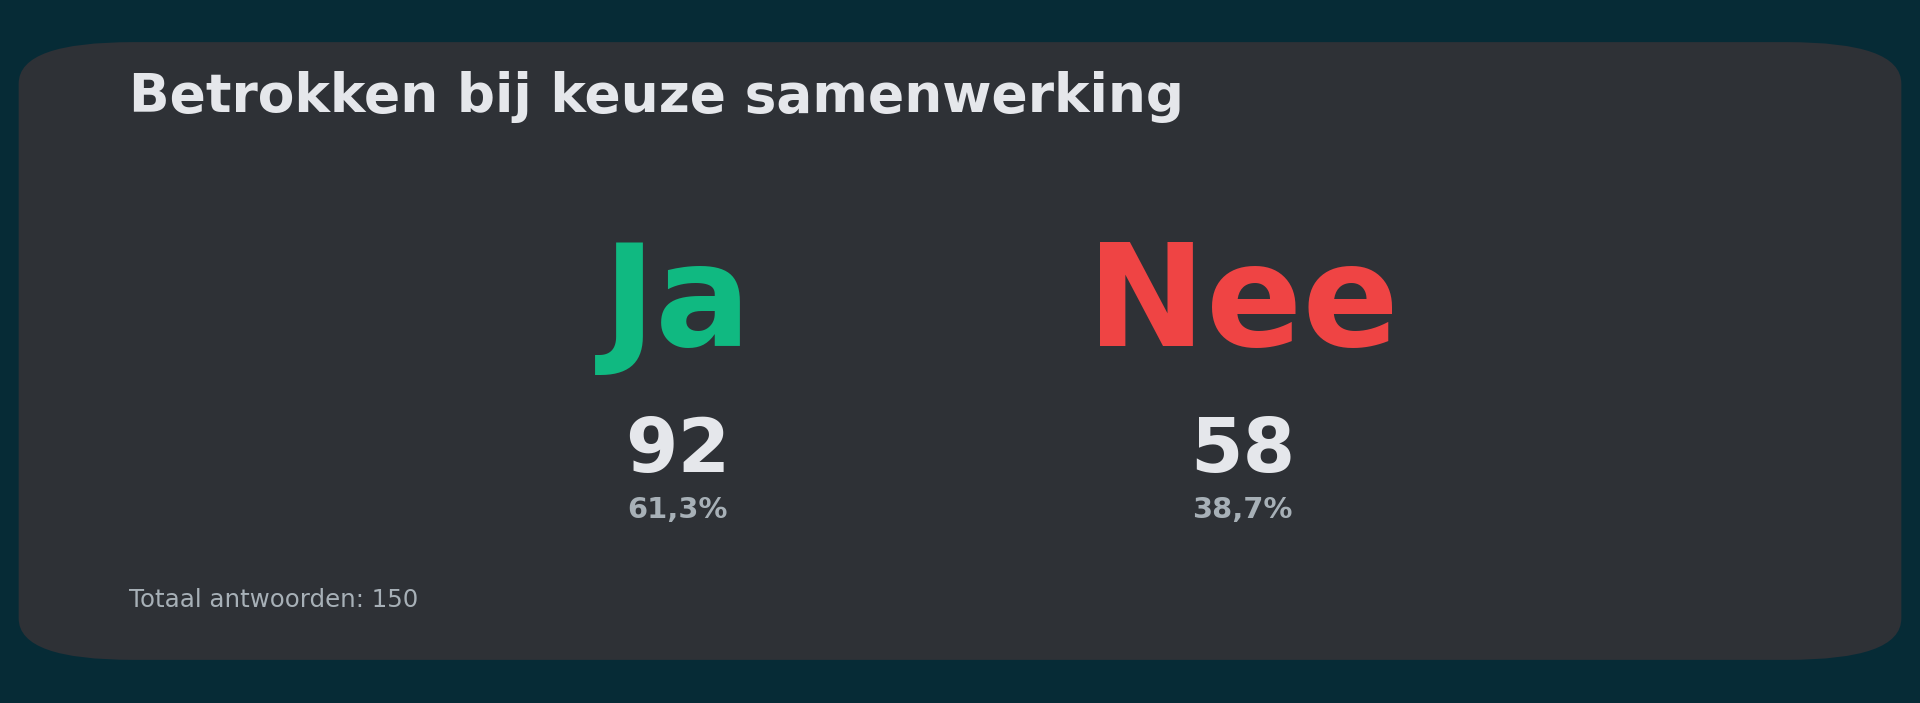

Figure(1888x672)


In [ ]:
# ----------------- Big JA/NEE card met dummydata -----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Dashboard-stijl (kan je overschrijven als je al globals hebt)
BG     = globals().get("BG",     "#062B36")
CARD   = globals().get("CARD",   "#2E3136")
TEXT   = globals().get("TEXT",   "#E5E7EB")
SUBTLE = globals().get("SUBTLE", "#A7B0B7")
TEAL   = globals().get("TEAL",   "#10B981")   # groen
RED    = globals().get("RED",    "#EF4444")   # rood

def create_big_yes_no_card(df: pd.DataFrame, column: str,
                           title: str = "Betrokken bij keuze samenwerking"):
    """Kaart met grote JA (groen) en NEE (rood), aantallen + percentages."""
    def to_bool(v):
        if pd.isna(v): return None
        if isinstance(v, (int, float, np.integer, np.floating)):
            iv = int(v)
            if iv == 1:  return True
            if iv in (0, 2): return False
            return None
        s = str(v).strip().lower()
        if s in {"ja","yes","y","true","1"}:  return True
        if s in {"nee","no","n","false","0"}: return False
        return None

    mapped = df[column].map(to_bool).dropna()
    n_yes  = int((mapped == True).sum())
    n_no   = int((mapped == False).sum())
    total  = n_yes + n_no
    if total == 0:
        print("Geen ja/nee-waarden gevonden."); return None

    fig = plt.figure(figsize=(11.8, 4.2), dpi=160)
    ax_card = fig.add_axes([0,0,1,1]); ax_card.axis("off")
    ax_card.set_xlim(0,1); ax_card.set_ylim(0,1)
    ax_card.add_patch(FancyBboxPatch(
        (0.02,0.06), 0.96, 0.88,
        boxstyle="round,pad=0.018,rounding_size=0.06",
        facecolor=CARD, edgecolor=CARD
    ))
    fig.text(0.06, 0.88, title, fontsize=24, weight="bold", color=TEXT, ha="left", va="center")

    ax = fig.add_axes([0.06, 0.10, 0.88, 0.72]); ax.axis("off")
    JA_X, NEE_X, TOP_Y, COUNT_Y, SUB_Y = 0.33, 0.67, 0.65, 0.35, 0.23

    ax.text(JA_X,  TOP_Y, "Ja",  ha="center", va="center", fontsize=64, weight="bold",
            color=TEAL, transform=ax.transAxes)
    ax.text(NEE_X, TOP_Y, "Nee", ha="center", va="center", fontsize=64, weight="bold",
            color=RED,  transform=ax.transAxes)

    ax.text(JA_X, COUNT_Y, f"{n_yes}", ha="center", va="center",
            fontsize=34, weight="bold", color=TEXT, transform=ax.transAxes)
    ax.text(NEE_X, COUNT_Y, f"{n_no}",  ha="center", va="center",
            fontsize=34, weight="bold", color=TEXT, transform=ax.transAxes)

    ax.text(JA_X, SUB_Y,  f"{(n_yes/total)*100:.1f}%".replace(".", ","), ha="center", va="center",
            fontsize=13, color=SUBTLE, weight="bold", transform=ax.transAxes)
    ax.text(NEE_X, SUB_Y, f"{(n_no/total)*100:.1f}%".replace(".", ","),  ha="center", va="center",
            fontsize=13, color=SUBTLE, weight="bold", transform=ax.transAxes)

    fig.text(0.06, 0.12, f"Totaal antwoorden: {total}", color=SUBTLE, fontsize=11)
    fig.patch.set_facecolor(BG)
    plt.show()
    return fig

# ----------------- Dummyvariabelen -----------------
# Bepaal hier hoeveel JA/NEE je wilt zien
n_yes_dummy = 92
n_no_dummy  = 58

# Mix wat vormen (ja/nee/1/0/True/False) zodat de normalisatie duidelijk is
dummy_values = (["ja"] * (n_yes_dummy//2) +
                [1]    * (n_yes_dummy - n_yes_dummy//2) +
                ["nee"]* (n_no_dummy//2) +
                [0]    * (n_no_dummy - n_no_dummy//2))

df_dummy = pd.DataFrame({"Betrokken_dummy": dummy_values})

# ----------------- Plot -----------------
fig = create_big_yes_no_card(df_dummy, "Betrokken_dummy")
print(fig)


### Aspecten Prof

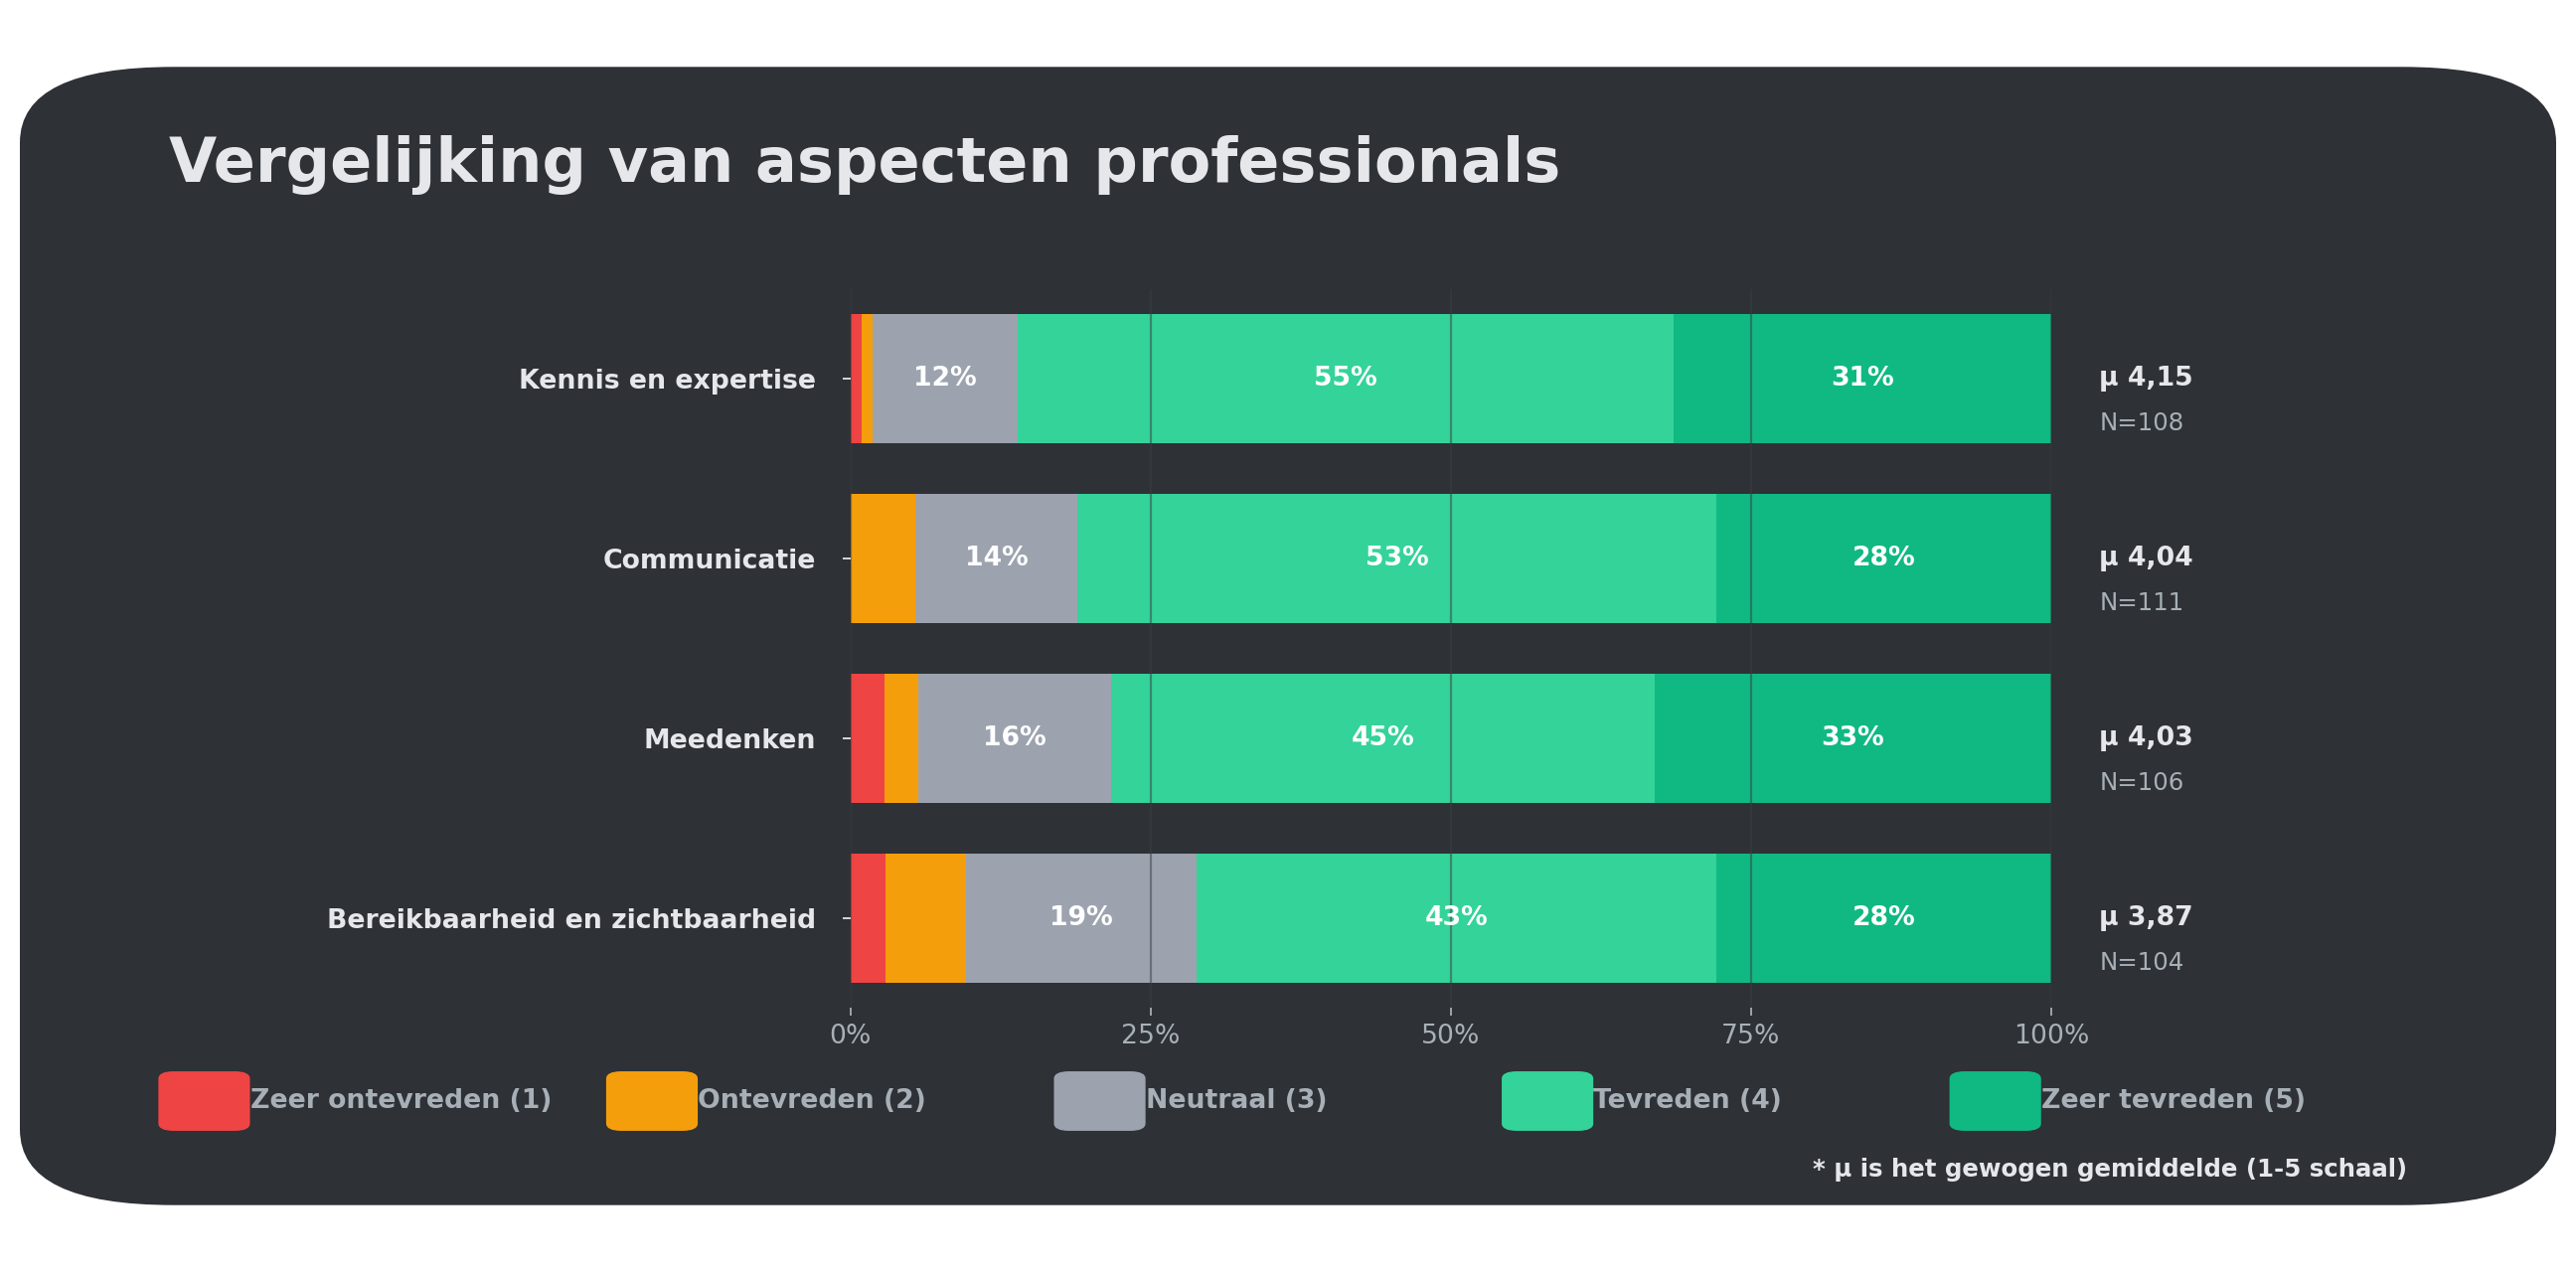

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from typing import Union

def create_aspecten_likert_card(
    df: pd.DataFrame,
    aspect_map: dict,
    title: str = "Vergelijking van aspecten professionals",
    sort_by: Union[str, None] = "mean",   # "mean", "positive", "very_pos", or None
):
    BG     = globals().get("BG",     "#062B36")
    CARD   = globals().get("CARD",   "#2E3136")
    GRID   = globals().get("GRID",   "#3A3D42")
    TEXT   = globals().get("TEXT",   "#E5E7EB")
    SUBTLE = globals().get("SUBTLE", "#A7B0B7")

    C_NEG2 = "#EF4444"; C_NEG1 = "#F59E0B"; C_NEUT = "#9CA3AF"; C_POS1 = "#34D399"; C_POS2 = "#10B981"
    COLORS = [C_NEG2, C_NEG1, C_NEUT, C_POS1, C_POS2]

    # Also supports string labels if they ever appear
    txt2code = {
        "zeer ontevreden": 1, "very dissatisfied": 1,
        "ontevreden": 2,     "dissatisfied": 2,
        "neutraal": 3,       "neutral": 3,
        "tevreden": 4,       "satisfied": 4,
        "zeer tevreden": 5,  "very satisfied": 5,
        "geen mening": np.nan, "nvt": np.nan
    }
    def normalize_ser(s: pd.Series) -> pd.Series:
        # numeric path: keep only 1..5; treat 6 ("geen mening") as NaN
        sn = pd.to_numeric(s, errors="coerce")
        if sn.notna().any():
            return sn.where(sn.isin([1,2,3,4,5]), np.nan)
        # textual path
        st = s.astype(str).str.strip().str.lower().map(txt2code)
        return pd.to_numeric(st, errors="coerce")

    rows = []
    for label, col in aspect_map.items():
        if col not in df.columns:
            rows.append((label, np.array([0,0,0,0,0], dtype=float), 0, np.nan))
            continue
        s = normalize_ser(df[col]).dropna().astype(int)
        N = len(s)
        if N == 0:
            rows.append((label, np.array([0,0,0,0,0], dtype=float), 0, np.nan))
            continue
        counts = s.value_counts().reindex([1,2,3,4,5], fill_value=0).astype(float).values
        fracs  = counts / counts.sum()
        mean   = (np.arange(1,6) * fracs).sum()
        rows.append((label, fracs, int(counts.sum()), float(mean)))

    # Sort with highest μ first - ensure NaN values are placed at the end
    if sort_by == "mean":
        rows.sort(key=lambda r: np.nan_to_num(r[3], nan=-np.inf), reverse=False)
    elif sort_by == "positive":
        rows.sort(key=lambda r: (r[1][3] + r[1][4]), reverse=True)
    elif sort_by in ("very_pos", "label5"):
        rows.sort(key=lambda r: r[1][4], reverse=True)

    labels = [r[0] for r in rows]
    frmat  = np.vstack([r[1] for r in rows]) if rows else np.zeros((0,5))
    Ns     = [r[2] for r in rows]
    means  = [r[3] for r in rows]

    k = len(labels)
    if k == 0:
        print("Geen aspecten om te tonen."); return None

    fig = plt.figure(figsize=(16.0, 1.0*k + 3.8), dpi=160)
    ax_card = fig.add_axes([0,0,1,1]); ax_card.axis("off")
    ax_card.set_xlim(0,1); ax_card.set_ylim(0,1)
    ax_card.add_patch(FancyBboxPatch((0.02, 0.06), 0.96, 0.88,
                                     boxstyle="round,pad=0.018,rounding_size=0.06",
                                     facecolor=CARD, edgecolor=CARD))
    fig.text(0.06, 0.88, title, fontsize=28, weight="bold", color=TEXT, ha="left", va="center")

    # Dynamic left margin so long labels sit inside the card
    max_label_len = max((len(label) for label in labels), default=0)
    label_space = min(0.35, 0.08 + max_label_len * 0.008)
    left = max(0.08, label_space)
    right = 0.80
    width = right - left
    bottom, height = 0.20, 0.58

    ax = fig.add_axes([left, bottom, width, height])
    ax.set_facecolor(CARD)
    for sp in ax.spines.values(): sp.set_visible(False)
    ax.grid(axis="x", color=GRID, linewidth=1.0, alpha=0.5)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, k-0.5)

    # Verbeterde label weergave
    label_fontsize = min(16, max(12, 250 / max(max_label_len, 1)))
    ax.set_yticks(range(k), labels, color=TEXT, fontsize=label_fontsize, weight="bold")
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1], ["0%","25%","50%","75%","100%"], color=SUBTLE, fontsize=12)
    ax.tick_params(axis="y", colors=TEXT, pad=12)

    h = 0.72
    thresh = 0.08
    for i in range(k):
        f1, f2, f3, f4, f5 = frmat[i]
        leftpos = 0.0
        for w, c in zip([f1,f2,f3,f4,f5], [C_NEG2,C_NEG1,C_NEUT,C_POS1,C_POS2]):
            if w <= 0: 
                continue
            ax.barh(i, w, left=leftpos, color=c, edgecolor="none", height=h)
            if w >= thresh:
                ax.text(leftpos + w/2, i, f"{w*100:.0f}%", color="white",
                        ha="center", va="center", fontsize=12, weight="bold")
            leftpos += w

        m = means[i]
        text_x = 1.04
        if not np.isnan(m):
            ax.text(text_x, i, f"μ {m:.2f}".replace(".", ","), color=TEXT, ha="left", va="center",
                    fontsize=12, weight="bold", transform=ax.transData, clip_on=False)
        ax.text(text_x, i-0.25, f"N={Ns[i]}", color=SUBTLE, ha="left", va="center",
                fontsize=11, transform=ax.transData, clip_on=False)

    # Verbeterde legenda
    legend_labels = ["Zeer ontevreden (1)", "Ontevreden (2)", "Neutraal (3)", "Tevreden (4)", "Zeer tevreden (5)"]
    legend_y = 0.105
    for j, (lab, col) in enumerate(zip(legend_labels, COLORS)):
        x0 = 0.06 + j*0.176
        ax_card.add_patch(FancyBboxPatch((x0, legend_y), 0.028, 0.04,
                                         boxstyle="round,pad=0.004,rounding_size=0.006",
                                         facecolor=col, edgecolor="none", transform=ax_card.transAxes))
        fig.text(x0 + 0.032, legend_y + 0.02, lab, color=SUBTLE, fontsize=12, va="center", weight="bold")

    # Uitleg tekst rechtsonder
    fig.text(0.94, 0.06, "* μ is het gewogen gemiddelde (1-5 schaal)", color=TEXT, fontsize=11, 
             ha="right", va="bottom", weight="bold")

    fig.patch.set_facecolor("none")  # Make background transparent
    plt.show()
    return fig

# --- Aspect mapping (values 1..5 used; 6 = "geen mening" discarded) ---
if LABEL == "Resolu":
    aspect_map = {
        "Communicatie": "Blok_Resolu_Professional_page124_Question1",
        "Bereikbaarheid en zichtbaarheid": "Blok_Resolu_Professional_page124_Question2",
        "Meedenken": "Blok_Resolu_Professional_page124_Question3",
        "Bereikbaarheid en zichtbaarheid": "Blok_Resolu_Professional_page124_Question4",
        "Kennis en expertise": "Blok_Resolu_Professional_page124_Question5",
    }
elif LABEL == "PDG Health Services":
    aspect_map = {
        "Contact met professionals": "Blok8_CategorieProfessional_page117_Question1",
        "Manier van terugkoppeling": "Blok8_CategorieProfessional_page117_Question2",
        "Communicatie": "Blok8_CategorieProfessional_page117_Question3",
        "Bereikbaarheid": "Blok8_CategorieProfessional_page117_Question4",
        "Snelheid van leveren": "Blok8_CategorieProfessional_page117_Question5",
        "Toepasbaarheid & kwaliteit adviezen": "Blok8_CategorieProfessional_page117_Question6",
        "Het aanbod": "Blok8_CategorieProfessional_page117_Question7",
    }

# --- Build the chart (sorted by highest μ first) and save ---
fig = create_aspecten_likert_card(
    df=df,
    aspect_map=aspect_map,
    title="Vergelijking van aspecten professionals",
    sort_by="mean",
)
fig.savefig("output.png", dpi=200, bbox_inches="tight", transparent=True)

### PDG aspecten systemen

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from typing import Union

def create_aspecten_likert_card(
    df: pd.DataFrame,
    aspect_map: dict,
    title: str = "Vergelijking van aspecten systeem",
    sort_by: Union[str, None] = "mean",   # "mean", "positive", "very_pos", or None
):
    if not aspect_map:
        return None
        
    BG     = globals().get("BG",     "#062B36")
    CARD   = globals().get("CARD",   "#2E3136")
    GRID   = globals().get("GRID",   "#3A3D42")
    TEXT   = globals().get("TEXT",   "#E5E7EB")
    SUBTLE = globals().get("SUBTLE", "#A7B0B7")

    C_NEG2 = "#EF4444"; C_NEG1 = "#F59E0B"; C_NEUT = "#9CA3AF"; C_POS1 = "#34D399"; C_POS2 = "#10B981"
    COLORS = [C_NEG2, C_NEG1, C_NEUT, C_POS1, C_POS2]

    # Also supports string labels if they ever appear
    txt2code = {
        "zeer ontevreden": 1, "very dissatisfied": 1,
        "ontevreden": 2,     "dissatisfied": 2,
        "neutraal": 3,       "neutral": 3,
        "tevreden": 4,       "satisfied": 4,
        "zeer tevreden": 5,  "very satisfied": 5,
        "geen mening": np.nan, "nvt": np.nan
    }
    def normalize_ser(s: pd.Series) -> pd.Series:
        # numeric path: keep only 1..5; treat 6 ("geen mening") as NaN
        sn = pd.to_numeric(s, errors="coerce")
        if sn.notna().any():
            return sn.where(sn.isin([1,2,3,4,5]), np.nan)
        # textual path
        st = s.astype(str).str.strip().str.lower().map(txt2code)
        return pd.to_numeric(st, errors="coerce")

    rows = []
    for label, col in aspect_map.items():
        if col not in df.columns:
            rows.append((label, np.array([0,0,0,0,0], dtype=float), 0, np.nan))
            continue
        s = normalize_ser(df[col]).dropna().astype(int)
        N = len(s)
        if N == 0:
            rows.append((label, np.array([0,0,0,0,0], dtype=float), 0, np.nan))
            continue
        counts = s.value_counts().reindex([1,2,3,4,5], fill_value=0).astype(float).values
        fracs  = counts / counts.sum()
        mean   = (np.arange(1,6) * fracs).sum()
        rows.append((label, fracs, int(counts.sum()), float(mean)))

    # Sort with highest μ first - ensure NaN values are placed at the end
    if sort_by == "mean":
        rows.sort(key=lambda r: np.nan_to_num(r[3], nan=-np.inf), reverse=False)
    elif sort_by == "positive":
        rows.sort(key=lambda r: (r[1][3] + r[1][4]), reverse=True)
    elif sort_by in ("very_pos", "label5"):
        rows.sort(key=lambda r: r[1][4], reverse=True)

    labels = [r[0] for r in rows]
    frmat  = np.vstack([r[1] for r in rows]) if rows else np.zeros((0,5))
    Ns     = [r[2] for r in rows]
    means  = [r[3] for r in rows]

    k = len(labels)
    if k == 0:
        print("Geen aspecten om te tonen."); return None

    fig = plt.figure(figsize=(16.0, 1.0*k + 3.8), dpi=160)
    ax_card = fig.add_axes([0,0,1,1]); ax_card.axis("off")
    ax_card.set_xlim(0,1); ax_card.set_ylim(0,1)
    ax_card.add_patch(FancyBboxPatch((0.02, 0.06), 0.96, 0.88,
                                     boxstyle="round,pad=0.018,rounding_size=0.06",
                                     facecolor=CARD, edgecolor=CARD))
    fig.text(0.06, 0.88, title, fontsize=28, weight="bold", color=TEXT, ha="left", va="center")

    # Dynamic left margin so long labels sit inside the card
    max_label_len = max((len(label) for label in labels), default=0)
    label_space = min(0.35, 0.08 + max_label_len * 0.008)
    left = max(0.08, label_space)
    right = 0.80
    width = right - left
    bottom, height = 0.20, 0.58

    ax = fig.add_axes([left, bottom, width, height])
    ax.set_facecolor(CARD)
    for sp in ax.spines.values(): sp.set_visible(False)
    ax.grid(axis="x", color=GRID, linewidth=1.0, alpha=0.5)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, k-0.5)

    # Verbeterde label weergave
    label_fontsize = min(16, max(12, 250 / max(max_label_len, 1)))
    ax.set_yticks(range(k), labels, color=TEXT, fontsize=label_fontsize, weight="bold")
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1], ["0%","25%","50%","75%","100%"], color=SUBTLE, fontsize=12)
    ax.tick_params(axis="y", colors=TEXT, pad=12)

    h = 0.72
    thresh = 0.08
    for i in range(k):
        f1, f2, f3, f4, f5 = frmat[i]
        leftpos = 0.0
        for w, c in zip([f1,f2,f3,f4,f5], [C_NEG2,C_NEG1,C_NEUT,C_POS1,C_POS2]):
            if w <= 0: 
                continue
            ax.barh(i, w, left=leftpos, color=c, edgecolor="none", height=h)
            if w >= thresh:
                ax.text(leftpos + w/2, i, f"{w*100:.0f}%", color="white",
                        ha="center", va="center", fontsize=12, weight="bold")
            leftpos += w

        m = means[i]
        text_x = 1.04
        if not np.isnan(m):
            ax.text(text_x, i, f"μ {m:.2f}".replace(".", ","), color=TEXT, ha="left", va="center",
                    fontsize=12, weight="bold", transform=ax.transData, clip_on=False)
        ax.text(text_x, i-0.25, f"N={Ns[i]}", color=SUBTLE, ha="left", va="center",
                fontsize=11, transform=ax.transData, clip_on=False)

    # Verbeterde legenda
    legend_labels = ["Zeer ontevreden (1)", "Ontevreden (2)", "Neutraal (3)", "Tevreden (4)", "Zeer tevreden (5)"]
    legend_y = 0.105
    for j, (lab, col) in enumerate(zip(legend_labels, COLORS)):
        x0 = 0.06 + j*0.176
        ax_card.add_patch(FancyBboxPatch((x0, legend_y), 0.028, 0.04,
                                         boxstyle="round,pad=0.004,rounding_size=0.006",
                                         facecolor=col, edgecolor="none", transform=ax_card.transAxes))
        fig.text(x0 + 0.032, legend_y + 0.02, lab, color=SUBTLE, fontsize=12, va="center", weight="bold")

    # Uitleg tekst rechtsonder
    fig.text(0.94, 0.06, "* μ is het gewogen gemiddelde (1-5 schaal)", color=TEXT, fontsize=11, 
             ha="right", va="bottom", weight="bold")

    fig.patch.set_facecolor("none")  # Make background transparent
    plt.show()
    return fig

if LABEL == "PDG Health Services":
        # --- Aspect mapping (values 1..5 used; 6 = "geen mening" discarded) ---
        aspect_map = {
            "Gebruiksvriendelijkheid": "Blok8_Systeem_page119_Question1",
            "Functionaliteit": "Blok8_Systeem_page119_Question2",
            "Beschikbaarheid": "Blok8_Systeem_page119_Question3",
            "Support": "Blok8_Systeem_page119_Question4"
        }
else:
        # --- Aspect mapping (values 1..5 used; 6 = "geen mening" discarded) ---
    aspect_map = {}

# --- Build the chart (sorted by highest μ first) and save ---
fig = create_aspecten_likert_card(
    df=df,
    aspect_map=aspect_map,
    title="Vergelijking van aspecten systeem",
    sort_by="mean",
)
if fig is not None:
    fig.savefig("output.png", dpi=200, bbox_inches="tight", transparent=True)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from typing import Union

def create_combined_aspecten_card(
    df: pd.DataFrame,
    aspect_map_prof: dict,
    aspect_map_sys: dict,
    sort_by: Union[str, None] = "mean",   # "mean", "positive", "very_pos", or None
    title_prof: str = "Vergelijking van aspecten professionals",
    title_sys: str = "Vergelijking van aspecten systeem",
):
    BG     = globals().get("BG",     "#062B36")
    CARD   = globals().get("CARD",   "#2E3136")
    GRID   = globals().get("GRID",   "#3A3D42")
    TEXT   = globals().get("TEXT",   "#E5E7EB")
    SUBTLE = globals().get("SUBTLE", "#A7B0B7")

    C_NEG2 = "#EF4444"; C_NEG1 = "#F59E0B"; C_NEUT = "#9CA3AF"; C_POS1 = "#34D399"; C_POS2 = "#10B981"
    COLORS = [C_NEG2, C_NEG1, C_NEUT, C_POS1, C_POS2]

    txt2code = {
        "zeer ontevreden": 1, "very dissatisfied": 1,
        "ontevreden": 2,     "dissatisfied": 2,
        "neutraal": 3,       "neutral": 3,
        "tevreden": 4,       "satisfied": 4,
        "zeer tevreden": 5,  "very satisfied": 5,
        "geen mening": np.nan, "nvt": np.nan
    }
    def normalize_ser(s: pd.Series) -> pd.Series:
        # Try numeric, but only if column is actually numeric or mostly numeric
        sn = pd.to_numeric(s, errors="coerce")
        numeric_ratio = sn.notna().mean()
        if pd.api.types.is_numeric_dtype(s) or numeric_ratio >= 0.8:
            return sn.where(sn.isin([1,2,3,4,5]), np.nan)

        # Textual path
        st = s.astype(str).str.strip().str.lower()
        mapped = st.map(txt2code)

        # If mapping is still empty, try extracting a 1..5 from strings like "1 - ..." or "(3)"
        if mapped.notna().sum() == 0:
            extracted = st.str.extract(r"\b([1-5])\b", expand=False)
            mapped = pd.to_numeric(extracted, errors="coerce")

        return mapped

    def compute_rows(amap: dict):
        rows = []
        for label, col in amap.items():
            if col not in df.columns:
                rows.append((label, np.array([0,0,0,0,0], dtype=float), 0, np.nan))
                continue
            s = normalize_ser(df[col]).dropna().astype(int)
            N = len(s)
            if N == 0:
                rows.append((label, np.array([0,0,0,0,0], dtype=float), 0, np.nan))
                continue
            counts = s.value_counts().reindex([1,2,3,4,5], fill_value=0).astype(float).values
            fracs  = counts / counts.sum()
            mean   = (np.arange(1,6) * fracs).sum()
            rows.append((label, fracs, int(counts.sum()), float(mean)))

        if sort_by == "mean":
            rows.sort(key=lambda r: np.nan_to_num(r[3], nan=-np.inf), reverse=False)
        elif sort_by == "positive":
            rows.sort(key=lambda r: (r[1][3] + r[1][4]), reverse=True)
        elif sort_by in ("very_pos", "label5"):
            rows.sort(key=lambda r: r[1][4], reverse=True)

        labels = [r[0] for r in rows]
        frmat  = np.vstack([r[1] for r in rows]) if rows else np.zeros((0,5))
        Ns     = [r[2] for r in rows]
        means  = [r[3] for r in rows]
        return labels, frmat, Ns, means

    labels_p, frmat_p, Ns_p, means_p = compute_rows(aspect_map_prof or {})
    labels_s, frmat_s, Ns_s, means_s = compute_rows(aspect_map_sys or {})

    k1, k2 = len(labels_p), len(labels_s)
    if k1 + k2 == 0:
        print("Geen aspecten om te tonen."); 
        return None

    # Dynamic figure height so both blocks fit comfortably
    fig_h = 3.8 + 0.9*(k1 + k2) + (0.6 if (k1 and k2) else 0.2)
    fig = plt.figure(figsize=(16.0, fig_h/1.6), dpi=160)
    ax_card = fig.add_axes([0,0,1,1]); ax_card.axis("off")
    ax_card.set_xlim(0,1); ax_card.set_ylim(0,1)
    ax_card.add_patch(FancyBboxPatch((0.02, 0.10), 0.96, 0.80,
                                     boxstyle="round,pad=0.018,rounding_size=0.06",
                                     facecolor=CARD, edgecolor=CARD))

    # Layout parameters inside the card
    max_label_len = max((len(l) for l in (labels_p + labels_s) or [""]), default=0)
    label_space = min(0.35, 0.08 + max_label_len * 0.008)
    left = max(0.08, label_space)
    right = 0.80
    width = right - left

    # Vertical slots
    y_card_top, y_card_bottom = 0.90, 0.10
    inner_top = y_card_top - 0.02
    inner_bottom = y_card_bottom + 0.08
    title_gap = 0.035
    between_gap = 0.045 if (k1 and k2) else 0.0
    available = (inner_top - inner_bottom) - (title_gap if k1 else 0) - (title_gap if k2 else 0) - between_gap
    total_rows = max(k1 + k2, 1)
    h1 = available * (k1/total_rows) if k1 else 0
    h2 = available * (k2/total_rows) if k2 else 0

    # Professionals block
    cur_top = inner_top
    if k1:
        fig.text(0.06, cur_top, title_prof, fontsize=24, weight="bold", color=TEXT, ha="left", va="top")
        cur_top -= title_gap
        ax1 = fig.add_axes([left, cur_top - h1, width, h1])
        _plot_likert_block(ax1, labels_p, frmat_p, Ns_p, means_p, COLORS, CARD, GRID, TEXT, SUBTLE)
        cur_top = cur_top - h1

    # Gap + Systeem block
    if k2:
        cur_top -= between_gap
        fig.text(0.06, cur_top, title_sys, fontsize=24, weight="bold", color=TEXT, ha="left", va="top")
        cur_top -= title_gap
        ax2 = fig.add_axes([left, cur_top - h2, width, h2])
        _plot_likert_block(ax2, labels_s, frmat_s, Ns_s, means_s, COLORS, CARD, GRID, TEXT, SUBTLE)
        cur_top = cur_top - h2

    # Legend UNDER the card (only once, because it's the last)
    legend_labels = ["Zeer ontevreden (1)", "Ontevreden (2)", "Neutraal (3)", "Tevreden (4)", "Zeer tevreden (5)"]
    legend_y = 0.06
    for j, (lab, col) in enumerate(zip(legend_labels, COLORS)):
        x0 = 0.06 + j*0.176
        fig.add_axes([x0, legend_y-0.010, 0.028, 0.040]).axis("off")
        ax_card.add_patch(FancyBboxPatch((x0, legend_y-0.010), 0.028, 0.040,
                                         boxstyle="round,pad=0.004,rounding_size=0.006",
                                         facecolor=col, edgecolor="none", transform=ax_card.transAxes))
        fig.text(x0 + 0.032, legend_y + 0.010, lab, color=SUBTLE, fontsize=12, va="center", weight="bold")

    fig.text(0.94, 0.02, "* μ is het gewogen gemiddelde (1-5 schaal)", color=TEXT, fontsize=11,
             ha="right", va="bottom", weight="bold")

    fig.patch.set_facecolor("none")
    plt.show()
    return fig

def _plot_likert_block(ax, labels, frmat, Ns, means, COLORS, CARD, GRID, TEXT, SUBTLE):
    ax.set_facecolor(CARD)
    for sp in ax.spines.values(): sp.set_visible(False)
    ax.grid(axis="x", color=GRID, linewidth=1.0, alpha=0.5)
    k = len(labels)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, k-0.5)
    label_fontsize = min(16, max(12, 250 / max((max(map(len, labels)) if labels else 1), 1)))
    ax.set_yticks(range(k), labels, color=TEXT, fontsize=label_fontsize, weight="bold")
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1], ["0%","25%","50%","75%","100%"], color=SUBTLE, fontsize=12)
    ax.tick_params(axis="y", colors=TEXT, pad=12)

    hbar = 0.72
    thresh = 0.08
    for i in range(k):
        f1, f2, f3, f4, f5 = frmat[i]
        leftpos = 0.0
        for w, c in zip([f1,f2,f3,f4,f5], COLORS):
            if w <= 0: 
                continue
            ax.barh(i, w, left=leftpos, color=c, edgecolor="none", height=hbar)
            if w >= thresh:
                ax.text(leftpos + w/2, i, f"{w*100:.0f}%", color="white",
                        ha="center", va="center", fontsize=12, weight="bold")
            leftpos += w

        m = means[i]
        text_x = 1.04
        if not np.isnan(m):
            ax.text(text_x, i, f"μ {m:.2f}".replace(".", ","), color=TEXT, ha="left", va="center",
                    fontsize=12, weight="bold", transform=ax.transData, clip_on=False)
        ax.text(text_x, i-0.25, f"N={Ns[i]}", color=SUBTLE, ha="left", va="center",
                fontsize=11, transform=ax.transData, clip_on=False)

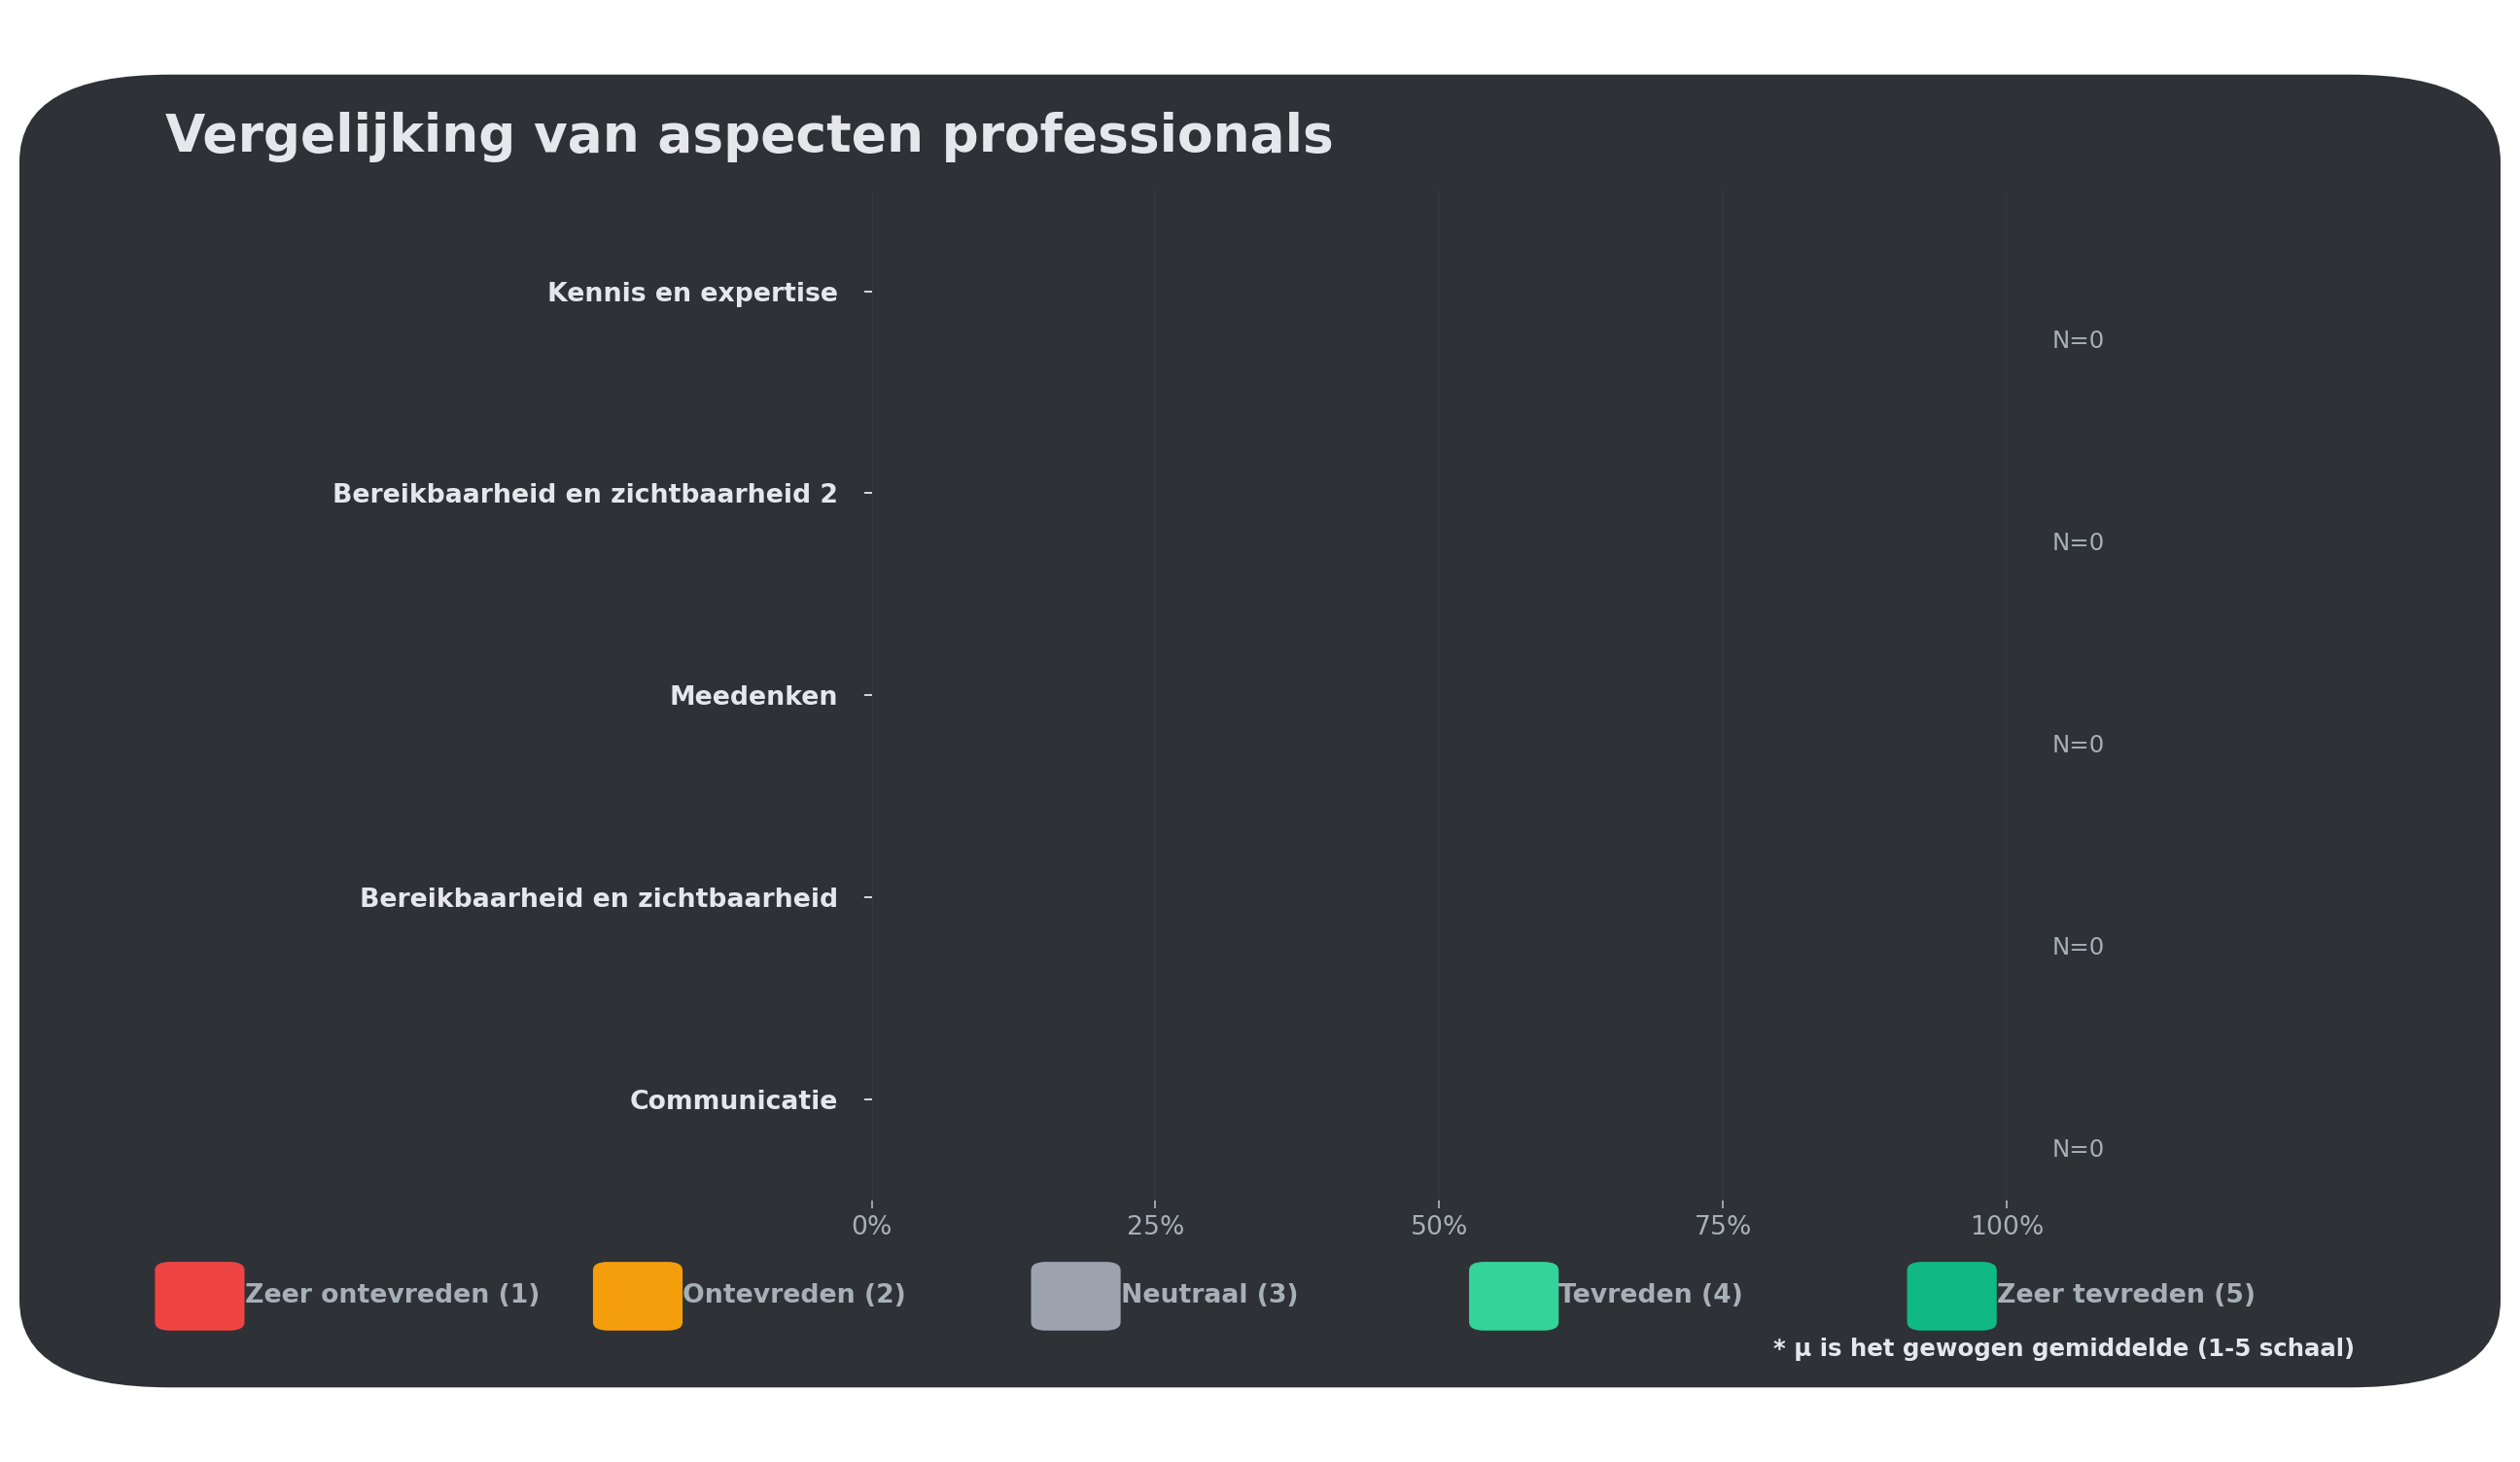

In [719]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from typing import Union

def create_aspecten_likert_combined(
    df: pd.DataFrame,
    aspect_map_prof: dict,
    aspect_map_sys: dict,
    sort_by_prof: Union[str, None] = "mean",
    sort_by_sys: Union[str, None] = "mean",
    title_prof: str = "Vergelijking van aspecten professionals",
    title_sys: str  = "Vergelijking van aspecten systeem",
    debug: bool = False,
):
    BG     = globals().get("BG",     "#062B36")
    CARD   = globals().get("CARD",   "#2E3136")
    GRID   = globals().get("GRID",   "#3A3D42")
    TEXT   = globals().get("TEXT",   "#E5E7EB")
    SUBTLE = globals().get("SUBTLE", "#A7B0B7")

    C_NEG2 = "#EF4444"; C_NEG1 = "#F59E0B"; C_NEUT = "#9CA3AF"; C_POS1 = "#34D399"; C_POS2 = "#10B981"
    COLORS = [C_NEG2, C_NEG1, C_NEUT, C_POS1, C_POS2]

    txt2code = {
        "zeer ontevreden": 1, "very dissatisfied": 1,
        "ontevreden": 2,     "dissatisfied": 2,
        "neutraal": 3,       "neutral": 3,
        "tevreden": 4,       "satisfied": 4,
        "zeer tevreden": 5,  "very satisfied": 5,
        "geen mening": np.nan, "nvt": np.nan
    }
    def normalize_ser(s: pd.Series) -> pd.Series:
        sn = pd.to_numeric(s, errors="coerce")
        if sn.notna().any():
            return sn.where(sn.isin([1,2,3,4,5]), np.nan)
        st = s.astype(str).str.strip().str.lower().map(txt2code)
        return pd.to_numeric(st, errors="coerce")

    def _norm(s: str) -> str:
        return re.sub(r"[^a-z0-9]", "", s.lower())

    cols = list(df.columns)
    norm_map = {_norm(c): c for c in cols}

    def resolve_col(col_hint: str) -> Union[str, None]:
        if col_hint in df.columns:
            return col_hint
        key = _norm(col_hint)
        if key in norm_map:
            return norm_map[key]
        # substring fallback
        for c in cols:
            if key and key in _norm(c):
                return c
        return None

    def prep_rows(aspect_map: dict, sort_by: Union[str, None], section_name: str):
        labels, frmat, Ns, means = [], [], [], []
        missing = []
        for label, col_hint in aspect_map.items():
            col = resolve_col(col_hint)
            if col is None:
                missing.append((label, col_hint))
                labels.append(label); frmat.append([0,0,0,0,0]); Ns.append(0); means.append(np.nan)
                continue
            s = normalize_ser(df[col]).dropna().astype(int)
            if len(s) == 0:
                labels.append(label); frmat.append([0,0,0,0,0]); Ns.append(0); means.append(np.nan)
                continue
            counts = s.value_counts().reindex([1,2,3,4,5], fill_value=0).astype(float).values
            fracs  = counts / counts.sum()
            mean   = (np.arange(1,6) * fracs).sum()
            labels.append(label); frmat.append(fracs); Ns.append(int(counts.sum())); means.append(float(mean))
        rows = list(zip(labels, frmat, Ns, means))
        if sort_by == "mean":
            rows.sort(key=lambda r: np.nan_to_num(r[3], nan=-np.inf), reverse=True)  # highest μ first
        elif sort_by == "positive":
            rows.sort(key=lambda r: (r[1][3] + r[1][4]), reverse=True)
        elif sort_by in ("very_pos", "label5"):
            rows.sort(key=lambda r: r[1][4], reverse=True)
        labels = [r[0] for r in rows]
        frmat  = np.vstack([r[1] for r in rows]) if rows else np.zeros((0,5))
        Ns     = [r[2] for r in rows]
        means  = [r[3] for r in rows]
        if debug and missing:
            print(f"[{section_name}] Ontbrekende kolommen:", missing)
        return labels, frmat, Ns, means

    labels1, frmat1, Ns1, means1 = prep_rows(aspect_map_prof, sort_by_prof, "Professionals")
    labels2, frmat2, Ns2, means2 = prep_rows(aspect_map_sys,  sort_by_sys,  "Systeem")

    k1, k2 = len(labels1), len(labels2)
    if k1 == 0 and k2 == 0:
        print("Geen aspecten om te tonen."); return None

    # Dynamic figure height
    total_rows = max(1, k1 + k2)
    fig_h = 1.0 * total_rows + 4.2
    fig = plt.figure(figsize=(16.0, fig_h), dpi=160)

    # Card
    ax_card = fig.add_axes([0,0,1,1]); ax_card.axis("off")
    ax_card.set_xlim(0,1); ax_card.set_ylim(0,1)
    ax_card.add_patch(FancyBboxPatch((0.02, 0.06), 0.96, 0.88,
                                     boxstyle="round,pad=0.018,rounding_size=0.06",
                                     facecolor=CARD, edgecolor=CARD))

    # Shared layout
    max_label_len = max([*(len(l) for l in labels1 or [""]), *(len(l) for l in labels2 or [""])])
    label_space = min(0.35, 0.08 + max_label_len * 0.008)
    left = max(0.08, label_space)
    right = 0.80
    width = right - left

    y_top, y_bot = 0.94, 0.06
    legend_h = 0.10
    title_h1 = 0.05 if k1 > 0 else 0.0
    title_h2 = 0.05 if k2 > 0 else 0.0
    gap = 0.012
    gap_between_sections = 0.02 if (k1 > 0 and k2 > 0) else 0.0

    avail = (y_top - y_bot) - legend_h - title_h1 - title_h2 - (2*gap) - gap_between_sections
    avail = max(0.20, avail)
    denom = max(1, (k1 if k1>0 else 0) + (k2 if k2>0 else 0))
    h1 = avail * ((k1 if k1>0 else 0) / denom)
    h2 = avail * ((k2 if k2>0 else 0) / denom)
    if k1 > 0 and k2 == 0: h1 = avail
    if k2 > 0 and k1 == 0: h2 = avail

    # Build top-down: professionals -> system -> legend
    cur_top = y_top

    # Professionals
    if k1 > 0:
        fig.text(0.06, cur_top - (title_h1/2), title_prof, fontsize=24, weight="bold", color=TEXT, ha="left", va="center")
        bottom1 = cur_top - title_h1 - gap - h1
        ax1 = fig.add_axes([left, bottom1, width, h1])
        ax1.set_facecolor(CARD)
        for sp in ax1.spines.values(): sp.set_visible(False)
        ax1.grid(axis="x", color=GRID, linewidth=1.0, alpha=0.5)
        ax1.set_xlim(0, 1); ax1.set_ylim(-0.5, k1-0.5)
        label_fontsize1 = min(16, max(12, 250 / max(max_label_len, 1)))
        ax1.set_yticks(range(k1), labels1, color=TEXT, fontsize=label_fontsize1, weight="bold")
        ax1.set_xticks([0, 0.25, 0.5, 0.75, 1], ["0%","25%","50%","75%","100%"], color=SUBTLE, fontsize=12)
        ax1.tick_params(axis="y", colors=TEXT, pad=12)
        h_bar = 0.72; thresh = 0.08
        for i in range(k1):
            f1,f2,f3,f4,f5 = frmat1[i]; leftpos = 0.0
            for w, c in zip([f1,f2,f3,f4,f5], [C_NEG2,C_NEG1,C_NEUT,C_POS1,C_POS2]):
                if w <= 0: continue
                ax1.barh(i, w, left=leftpos, color=c, edgecolor="none", height=h_bar)
                if w >= thresh:
                    ax1.text(leftpos + w/2, i, f"{w*100:.0f}%", color="white",
                             ha="center", va="center", fontsize=12, weight="bold")
                leftpos += w
            m = means1[i]; text_x = 1.04
            if not np.isnan(m):
                ax1.text(text_x, i, f"μ {m:.2f}".replace(".", ","), color=TEXT, ha="left", va="center",
                         fontsize=12, weight="bold", transform=ax1.transData, clip_on=False)
            ax1.text(text_x, i-0.25, f"N={Ns1[i]}", color=SUBTLE, ha="left", va="center",
                     fontsize=11, transform=ax1.transData, clip_on=False)
        cur_top = bottom1 - gap_between_sections

    # Systeem
    if k2 > 0:
        fig.text(0.06, cur_top - (title_h2/2), title_sys, fontsize=24, weight="bold", color=TEXT, ha="left", va="center")
        bottom2 = cur_top - title_h2 - gap - h2
        ax2 = fig.add_axes([left, bottom2, width, h2])
        ax2.set_facecolor(CARD)
        for sp in ax2.spines.values(): sp.set_visible(False)
        ax2.grid(axis="x", color=GRID, linewidth=1.0, alpha=0.5)
        ax2.set_xlim(0, 1); ax2.set_ylim(-0.5, k2-0.5)
        label_fontsize2 = min(16, max(12, 250 / max(max_label_len, 1)))
        ax2.set_yticks(range(k2), labels2, color=TEXT, fontsize=label_fontsize2, weight="bold")
        ax2.set_xticks([0, 0.25, 0.5, 0.75, 1], ["0%","25%","50%","75%","100%"], color=SUBTLE, fontsize=12)
        ax2.tick_params(axis="y", colors=TEXT, pad=12)
        h_bar = 0.72; thresh = 0.08
        for i in range(k2):
            f1,f2,f3,f4,f5 = frmat2[i]; leftpos = 0.0
            for w, c in zip([f1,f2,f3,f4,f5], [C_NEG2,C_NEG1,C_NEUT,C_POS1,C_POS2]):
                if w <= 0: continue
                ax2.barh(i, w, left=leftpos, color=c, edgecolor="none", height=h_bar)
                if w >= thresh:
                    ax2.text(leftpos + w/2, i, f"{w*100:.0f}%", color="white",
                             ha="center", va="center", fontsize=12, weight="bold")
                leftpos += w
            m = means2[i]; text_x = 1.04
            if not np.isnan(m):
                ax2.text(text_x, i, f"μ {m:.2f}".replace(".", ","), color=TEXT, ha="left", va="center",
                         fontsize=12, weight="bold", transform=ax2.transData, clip_on=False)
            ax2.text(text_x, i-0.25, f"N={Ns2[i]}", color=SUBTLE, ha="left", va="center",
                     fontsize=11, transform=ax2.transData, clip_on=False)

    # Legend (once, at bottom)
    legend_labels = ["Zeer ontevreden (1)", "Ontevreden (2)", "Neutraal (3)", "Tevreden (4)", "Zeer tevreden (5)"]
    legend_y = y_bot + 0.025
    for j, (lab, col) in enumerate(zip(legend_labels, COLORS)):
        x0 = 0.06 + j*0.176
        ax_card.add_patch(FancyBboxPatch((x0, legend_y), 0.028, 0.04,
                                         boxstyle="round,pad=0.004,rounding_size=0.006",
                                         facecolor=col, edgecolor="none", transform=ax_card.transAxes))
        fig.text(x0 + 0.032, legend_y + 0.02, lab, color=SUBTLE, fontsize=12, va="center", weight="bold")

    # Footnote
    fig.text(0.94, 0.06, "* μ is het gewogen gemiddelde (1-5 schaal)", color=TEXT, fontsize=11,
             ha="right", va="bottom", weight="bold")

    fig.patch.set_facecolor("none")
    plt.show()
    return fig
if LABEL == "Resolu":
    aspect_map_prof = {
        "Communicatie": "Blok_Resolu_Professional_page124_Question1",
        "Bereikbaarheid en zichtbaarheid": "Blok_Resolu_Professional_page124_Question2",
        "Meedenken": "Blok_Resolu_Professional_page124_Question3",
        "Bereikbaarheid en zichtbaarheid 2": "Blok_Resolu_Professional_page124_Question4",
        "Kennis en expertise": "Blok_Resolu_Professional_page124_Question5",
    }
    aspect_map_sys = {}
elif LABEL == "PDG Health Services":
    aspect_map_prof = {
        "Contact met professionals": "Blok8_CategorieProfessional_page117_Question1",
        "Manier van terugkoppeling": "Blok8_CategorieProfessional_page117_Question2",
        "Communicatie": "Blok8_CategorieProfessional_page117_Question3",
        "Bereikbaarheid": "Blok8_CategorieProfessional_page117_Question4",
        "Snelheid van leveren": "Blok8_CategorieProfessional_page117_Question5",
        "Toepasbaarheid & kwaliteit adviezen": "Blok8_CategorieProfessional_page117_Question6",
        "Het aanbod": "Blok8_CategorieProfessional_page117_Question7",
    }
    aspect_map_sys = {
        "Gebruiksvriendelijkheid": "Blok8_Systeem_page119_Question1",
        "Functionaliteit": "Blok8_Systeem_page119_Question2",
        "Beschikbaarheid": "Blok8_Systeem_page119_Question3",
        "Support": "Blok8_Systeem_page119_Question4"
    }
else:
    aspect_map_prof = {}
    aspect_map_sys  = {}

fig = create_aspecten_likert_combined(
    df=df,
    aspect_map_prof=aspect_map_prof,
    aspect_map_sys=aspect_map_sys,
    sort_by_prof="mean",
    sort_by_sys="mean",
    title_prof="Vergelijking van aspecten professionals",
    title_sys="Vergelijking van aspecten systeem",
    debug=True,
)
if fig is not None:
    fig.savefig("output.png", dpi=200, bbox_inches="tight", transparent=True)